# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In the present study I have performed the predictive analysis of the Tasty Bytes dataset (recipe_site_traffic.csv) using pandas, matplotlib, seaborn, and sklearn Python packages.

Objectives.

The Product Manager (Recipe Discovery) and the Head of Data Science of Tasty Bytes need predictive analysis on which recipes to display on the homepage each day to maximize traffic. 
The questions to be answered are the following:

- Predict which recipes will lead to high traffic?
- Correctly predict high traffic recipes 80% of the time?

Since the goal of the Tasty Bytes company is to increase the number of subscriptions and higher traffic correlates with it, I choose the 'high_traffic' column of the 'recipe_site_traffic.csv' as the target variable for the predictive analysis.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

pd.set_option('display.max_columns', None)
sns.set_palette('colorblind')

#Importing recipe_site_traffic.csv
recipe_traffic_df = pd.read_csv("recipe_site_traffic_2212.csv")
#print(recipe_traffic_df.head())
recipe_traffic_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


The exploratory analysis of the 'recipe_site_traffic.csv' dataset revealed the following:

1. The original 'recipe_site_traffic.csv' dataset consists of 8 columns: 'recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings', and 'high-traffic'. 

2. The 'recipe' column is of the right data type (dtype = 'int'), it has only unique values. Does not need cleaning.

3. Five of eight columns contain missing value: 'calories', 'carbohydrate', 'sugar', 'protein' have 52 missing values each, 'high_traffic' column has 373 missing values.

4. The data type of the 'category' column is of 'object' data type. It does not fit the data specification. The data type was changed to 'category' data type. The column contained inconsistent values: 'Chicken Breast'. Those values were replaced with 'Chicken' values.

5. The 'servings' column was of 'object' data type and also contained inconsistent values: '4 as a snack' and '6 as a snack'. Since the column data type was specified as 'int', I replaced the inconsistent values with 4 and 6, respectively, and changed the data type of the column from 'object' to 'int' dtype.

6. The data type of 'high_traffic' column was of the right data type (dtype='object'). I temporaly replaced 373 missing values with 'Unknown' for data visualization. 

In [3]:
#Identifying missing values
print('Missing values in recipe_traffic_df:')
print(recipe_traffic_df.isna().sum())

#Checking that 'recipe' column consists of unique values
print('Number of unique values in recipe column: ', recipe_traffic_df['recipe'].nunique())

#Replacing values in 'category' column
print(recipe_traffic_df['category'].value_counts())
recipe_traffic_df['category'] = recipe_traffic_df['category'].str.replace('Chicken Breast', 'Chicken')
print(recipe_traffic_df['category'].value_counts())

#Changing data type of 'category' column
recipe_traffic_df['category'] = recipe_traffic_df['category'].astype('category')
print(recipe_traffic_df['category'].dtype)

#Replacing values in 'servings' column
print(recipe_traffic_df['servings'].value_counts())
recipe_traffic_df['servings'] = recipe_traffic_df['servings'].str.replace('4 as a snack', '4')
recipe_traffic_df['servings'] = recipe_traffic_df['servings'].str.replace('6 as a snack', '6')
print(recipe_traffic_df['servings'].value_counts())

#Changing datatype of 'servings' column
recipe_traffic_df['servings'] = recipe_traffic_df['servings'].astype('int')
print(recipe_traffic_df['servings'].dtype)

#Replacing missing values in 'high_traffic' column with 'Unknown'.
recipe_traffic_df['high_traffic'] = recipe_traffic_df['high_traffic'].fillna("Unknown")
print(recipe_traffic_df['high_traffic'].value_counts())
print('__________________________')

recipe_traffic_df.info()

Missing values in recipe_traffic_df:
recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64
Number of unique values in recipe column:  947
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64
Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64
category
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64
4    391
6    198
2    183
1    175
Name: servings, dtype: int64
int64
High

7. To fill missing values in numerical columns of 'float' data type, I first checked the skewness of the columns.

In [4]:
#Calculating skewness of numerical columns
def calculate_skew(df):
    """ The function calculates skewness of numerical columns in pandas dataframe."""
    if df.empty:
       raise ValueError("The DataFrame is empty.")
    else:
        numerical_cols = df.select_dtypes(include=['float64']).columns
        # Calculate skewness for numerical columns
        skewness = df[numerical_cols].skew()
        print(f"Skewness:\n{skewness}")
    
skewness = calculate_skew(recipe_traffic_df)

Skewness:
calories        2.036151
carbohydrate    3.756980
sugar           4.223352
protein         3.509453
dtype: float64


Replacing missing values with the median is a best practice for handling skewed distributions. The reasons are the following:
- Skewness in Data: The four numerical columns ('calories', 'carbohydrate', 'sugar', and 'protein') showed high skew values, indicating that the distributions are highly positively skewed. In such cases, the median is often preferred over the mean for imputation because the median is less sensitive to extreme values and outliers, which aligns well with skewed distributions.
- Median Imputation: To address missing values, for each unique category in the 'category' column, I computed the median of the numerical columns within that category. This ensures that the imputed values are representative of the specific category, maintaining consistency within each group.
- Replace Missing Values: The missing values in each numerical column were then replaced with the median value calculated for the corresponding category. This approach helps in preserving the distribution characteristics within each category.
- Verification of Skewness: After the imputation process, I rechecked the skewness of the columns to ensure that the distribution was not significantly disturbed. This verification step is crucial for confirming that the imputation process did not introduce biases or alter the distribution in a way that would negatively impact subsequent analyses.
- Impact on Data Distribution: Using median imputation effectively preserved the overall shape and characteristics of the original distributions, which is especially important when dealing with skewed data. The median maintains robustness against outliers and ensures that the data remains representative of its categories.

In [5]:
recipe_traffic_df_new = recipe_traffic_df

#Replacing missing values in numetical columns with dtype = 'float'
def fillna_median(df, categorical_col):
    """The function replaces missing values in numerical columns (dtype = 'float') of pandas dataframe with medians for each category in categorical column."""
    if df.empty:
       raise ValueError("The DataFrame is empty.")
    else:
        numerical_cols = df.select_dtypes(include=['float']).columns
        for col in numerical_cols:
            df[col] = df[col].fillna(df.groupby(categorical_col)[col].transform('median'))
        return df
    
recipe_traffic_df_new = fillna_median(recipe_traffic_df, 'category') 
#print(recipe_traffic_df_new.head())

#Checking skewness after replacing missing values with medians for each category in 'category' column.
cleaned_df = recipe_traffic_df_new
skewness = calculate_skew(recipe_traffic_df_new)

cleaned_df.info()

Skewness:
calories        2.111087
carbohydrate    3.872229
sugar           4.290695
protein         3.589141
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        947 non-null    int64   
 1   calories      947 non-null    float64 
 2   carbohydrate  947 non-null    float64 
 3   sugar         947 non-null    float64 
 4   protein       947 non-null    float64 
 5   category      947 non-null    category
 6   servings      947 non-null    int64   
 7   high_traffic  947 non-null    object  
dtypes: category(1), float64(4), int64(2), object(1)
memory usage: 53.2+ KB


As the result, the cleaned_df (cleaned version of the original recipe_traffic_df) consists of 8 columns and 947 rows. the columns data type is in the agreement with the recipe_site_traffic_2212.csv data dictionary.

I applied np.log1p() transformation to the highly positively skewed numerical columns to improve the normality of the data distribution. 
- Right-Skewed Data: The original numerical columns ('calories', 'carbohydrate', 'sugar', and 'protein') exhibit positive skewness, meaning they have a long tail on the right side. This can complicate statistical analysis and modeling, as many methods assume normally distributed data.
- Log1p Transformation: The np.log1p() function applies the transformation log(1+x). This transformation is particularly effective for handling positive skewness because it compresses the range of large values and stretches the range of smaller values. This helps in making the data distribution more symmetric and less skewed.
- Variance Stabilization: By transforming the data, the variance becomes more stable across different ranges of values. This is crucial for predictive modeling, as many algorithms perform better when the data is normally distributed and variance is uniform.
- Normal Distribution: Applying the log transformation helps in approximating a normal distribution, which is a common assumption in many statistical techniques and machine learning models. This transformation facilitates more accurate and reliable predictions.
- Predictive Analysis: For predictive modeling, normality of the data is often assumed or preferred because many statistical and machine learning algorithms work under the assumption of normally distributed residuals or features. The log transformation makes the data more suitable for these models.

In [6]:
#Logarithmic transformation of the skewed numerical columns
def log_transformation(df):
    """The function applies log1p() transformation to the skewed numerical columns (dtype='float') in pandas dataframe."""
    if df.empty:
       raise ValueError("The DataFrame is empty.")
    else:
        numerical_cols = df.select_dtypes(include=['float']).columns
        for col in numerical_cols:
            df[col+'_log'] = np.log1p(df[col])
        return df
    
cleaned_df = log_transformation(cleaned_df)

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   recipe            947 non-null    int64   
 1   calories          947 non-null    float64 
 2   carbohydrate      947 non-null    float64 
 3   sugar             947 non-null    float64 
 4   protein           947 non-null    float64 
 5   category          947 non-null    category
 6   servings          947 non-null    int64   
 7   high_traffic      947 non-null    object  
 8   calories_log      947 non-null    float64 
 9   carbohydrate_log  947 non-null    float64 
 10  sugar_log         947 non-null    float64 
 11  protein_log       947 non-null    float64 
dtypes: category(1), float64(8), int64(2), object(1)
memory usage: 82.8+ KB


In Fig. 1, the seaborn histplots illustrate the distributions of four numerical columns—'calories', 'carbohydrate', 'sugar', and 'protein'—across three stages: the original data, the cleaned data after missing values replacement, and the log-transformed cleaned data. Here’s a summary of the findings:
- Original Data: The first column in the histplots shows the distribution of the original data for each numerical column (represented in blue). This provides a baseline view of the data before any cleaning or transformation.
- Cleaned Data: The second column displays the distribution of the cleaned data after missing values have been replaced (shown in yellow). This plot demonstrates that the data distribution was preserved through the cleaning process, with no significant distortions introduced by the replacement of missing values.
- Log-Transformed Data: The third column presents the log1p() transformed cleaned data (represented in green). The log transformation has effectively made the distributions more symmetrical and closer to a normal distribution. This transformation is useful for stabilizing variance and making the data more suitable for statistical modeling.

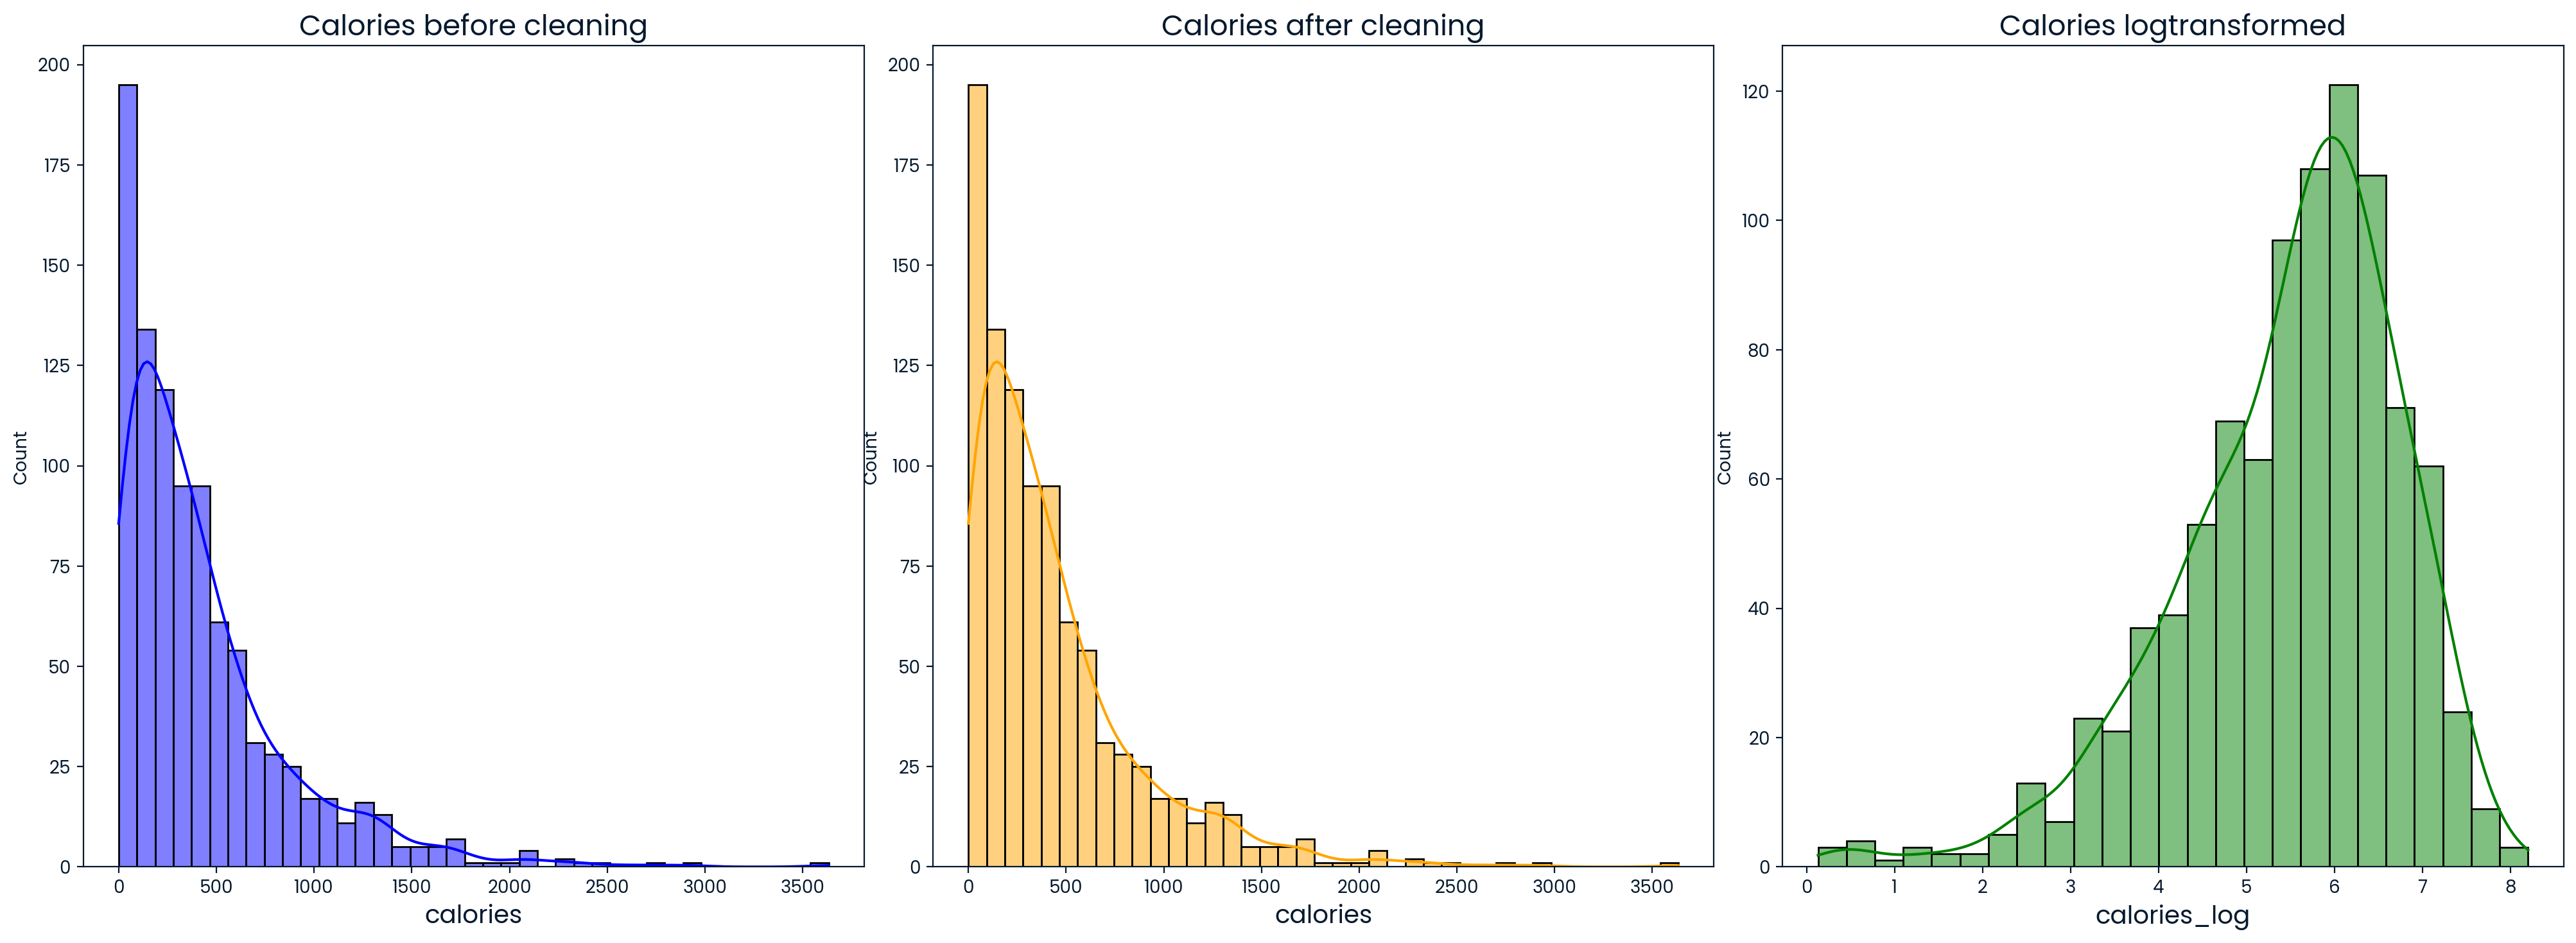

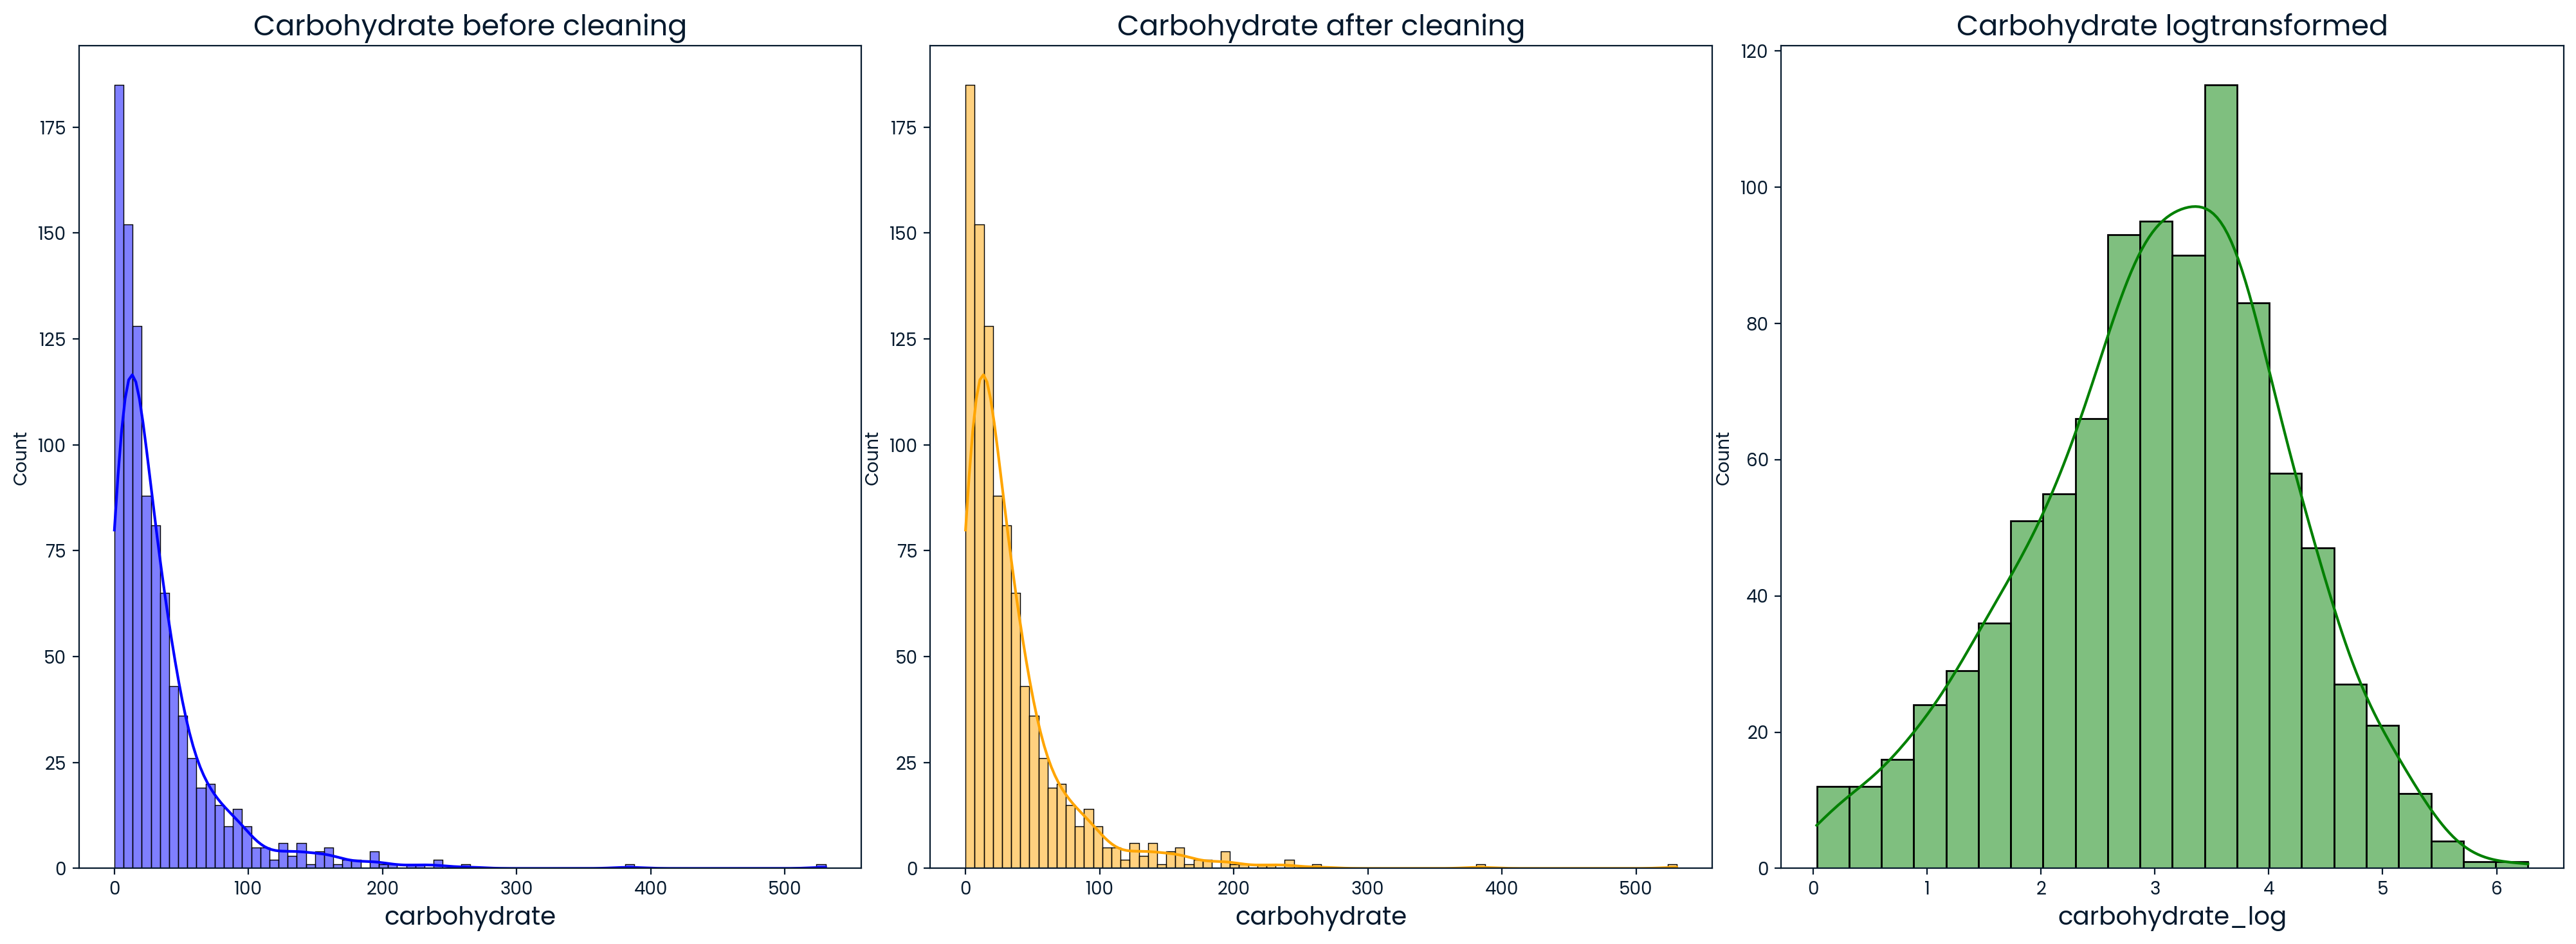

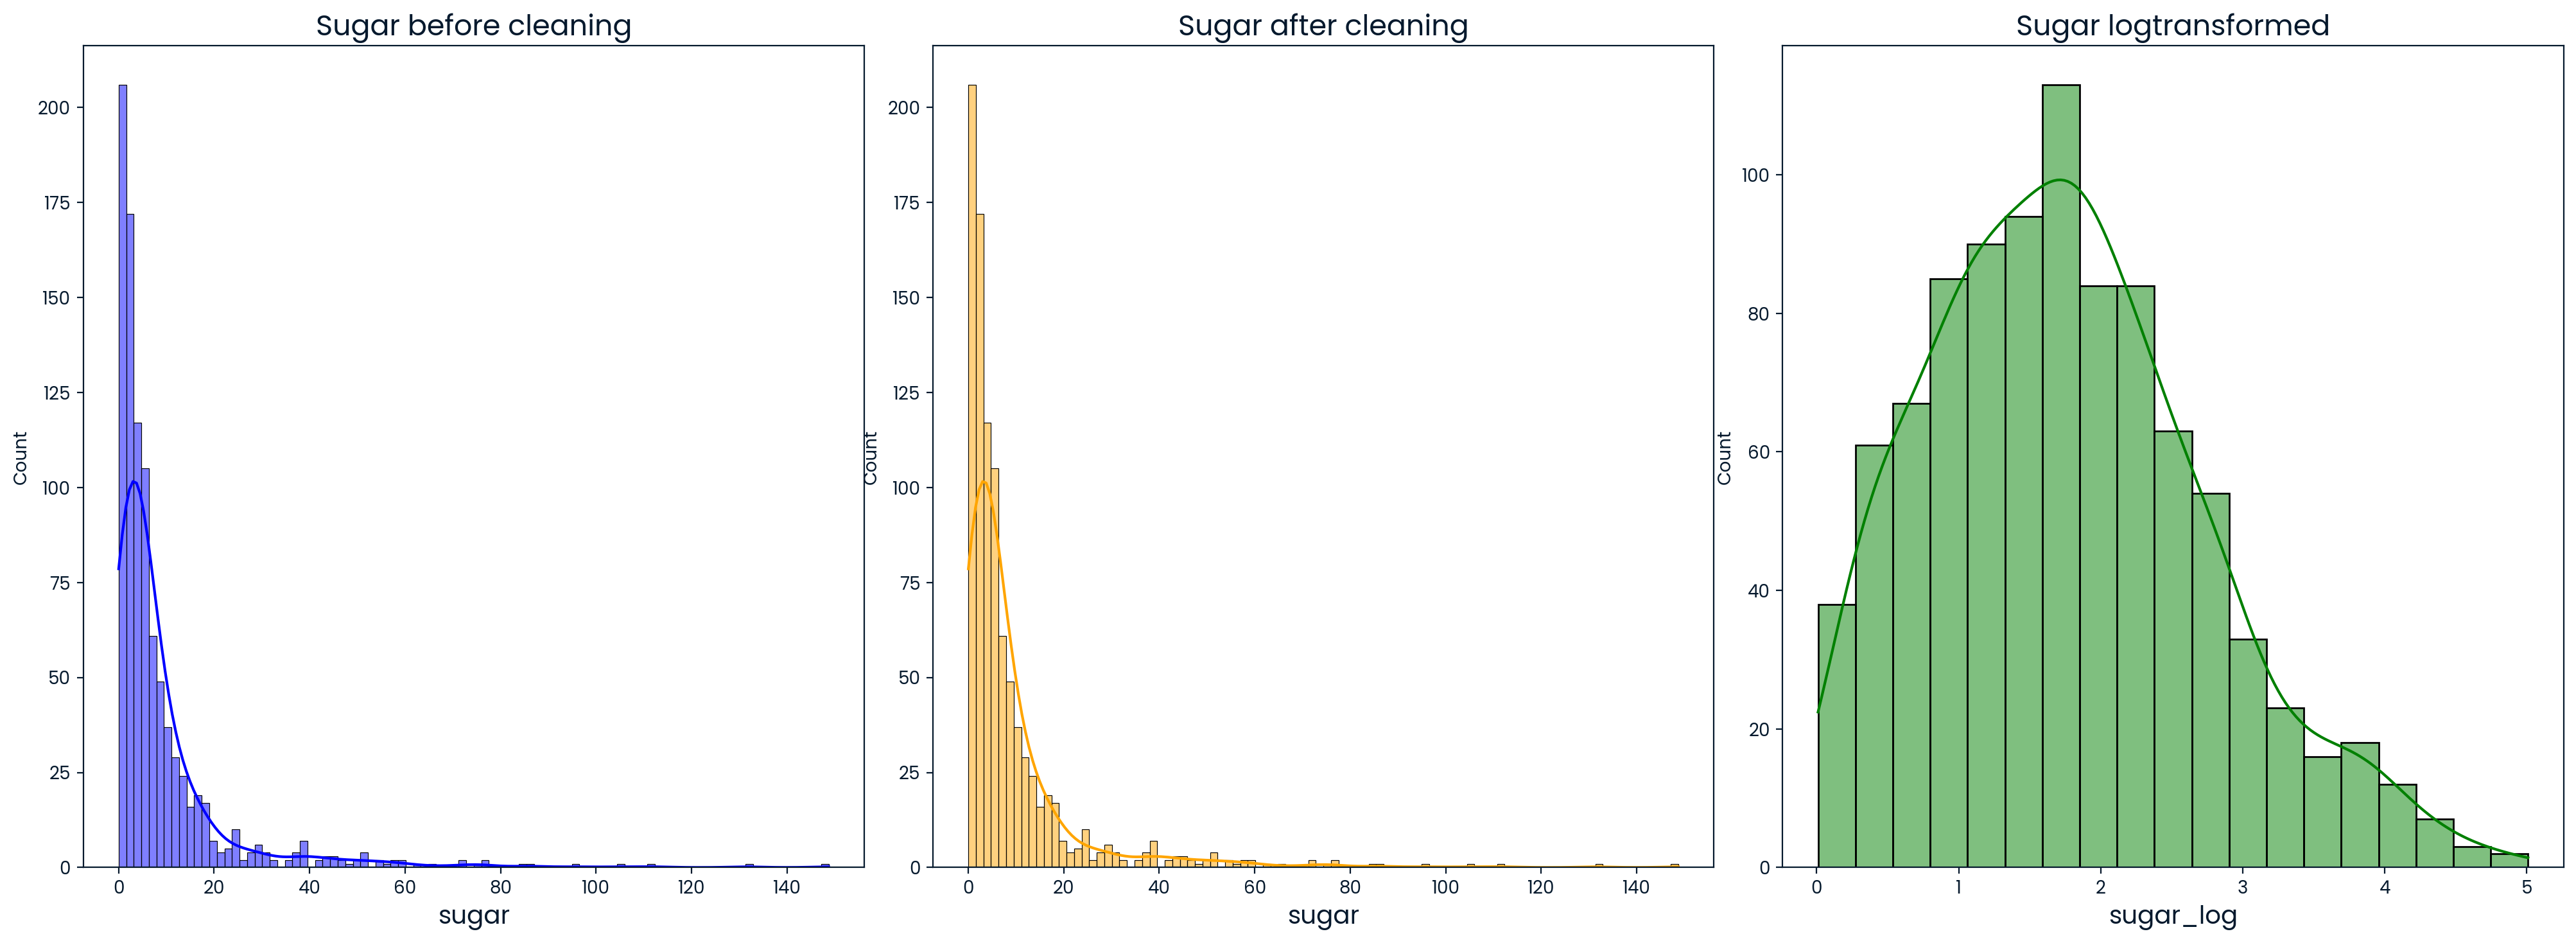

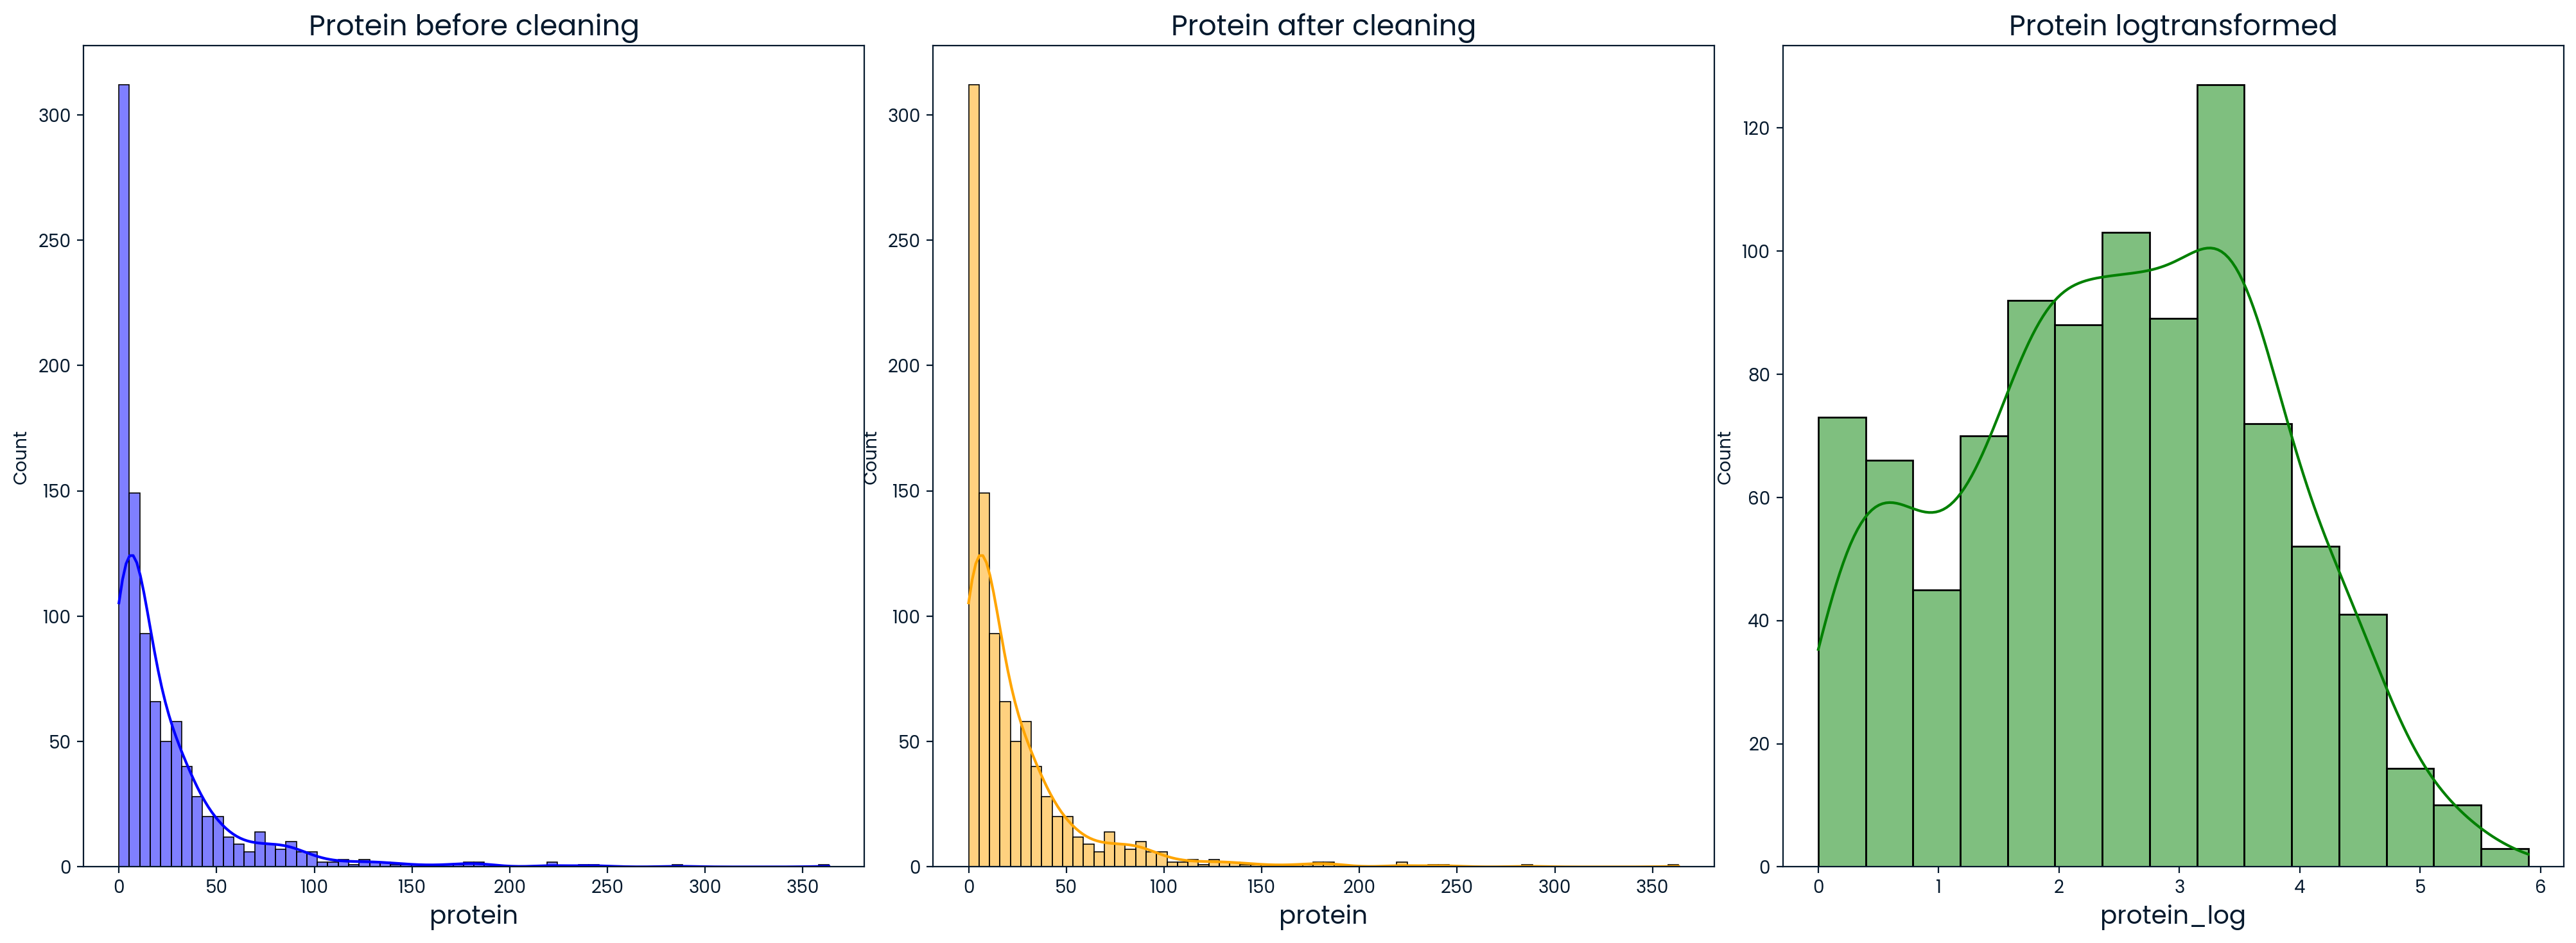

In [7]:
#Creating histplots
def plot_histplot(df1, column1, df2, column2):
    """The function creates  3 seaborn histplots of a numerical column (dtype='float') before cleaning, after imputing medians for missing values and after logarithmic transformation."""
    if df1.empty or df1.empty:
       raise ValueError("The DataFrame is empty.")
    else:
        fig, axes = plt.subplots(1,3, figsize=(20,7))
        plt.tight_layout()
        sns.histplot(df1[column1],color='blue', kde=True, ax=axes[0])
        axes[0].set_title(f"{column1.capitalize()} before cleaning", fontsize=16)
        axes[0].set_xlabel(f'{column1}', fontsize=14) 
        sns.histplot(df2[column1],color='orange', kde=True,ax=axes[1])
        axes[1].set_title(f"{column1.capitalize()} after cleaning", fontsize=16) 
        axes[1].set_xlabel(f'{column1}', fontsize=14)
        sns.histplot(df2[column2],color='green', kde=True, ax=axes[2])
        axes[2].set_title(f"{column1.capitalize()} logtransformed",  fontsize=16)
        axes[2].set_xlabel(f'{column2}', fontsize=14)
        plt.show()
        
plot_histplot(recipe_traffic_df, 'calories', cleaned_df, 'calories_log')
plot_histplot(recipe_traffic_df, 'carbohydrate', cleaned_df, 'carbohydrate_log')
plot_histplot(recipe_traffic_df, 'sugar', cleaned_df, 'sugar_log')
plot_histplot(recipe_traffic_df, 'protein', cleaned_df, 'protein_log')

In Fig. 2, the distribution of the 'servings' column is presented, revealing the following key insights:
- Distinct Values: The 'servings' column contains only four distinct values: 1, 2, 4, and 6.
- Mode Value: The most common value, or mode, is 4 servings, with 391 out of 947 total values, making it the most popular serving size for recipes.
- Least Common Value: The least common serving size is 1 serving, with only 175 recipes using this quantity.

Overall, this distribution indicates that recipes are predominantly designed to serve 4 people, while single-serving recipes are the least frequent. This might reflect common portion sizes or preferences in recipe design.

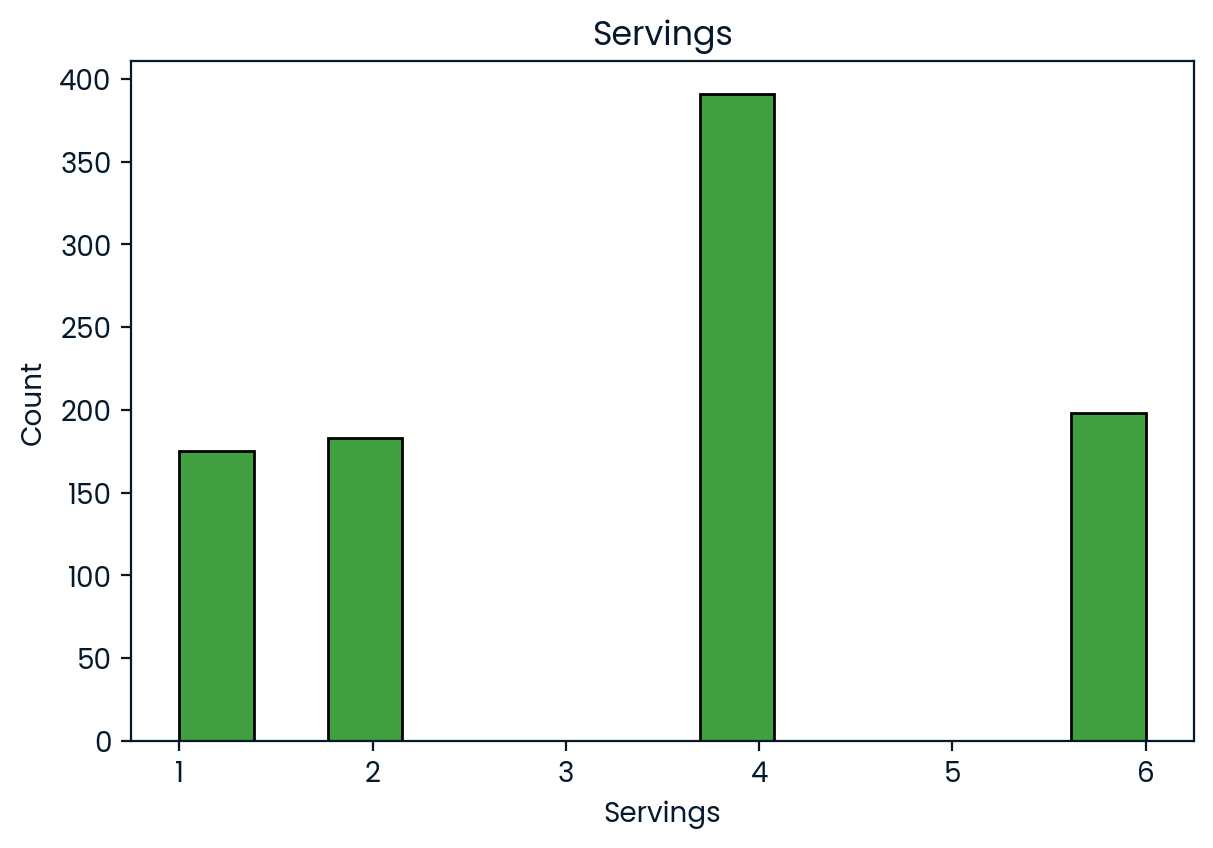

In [8]:
fig, axes = plt.subplots(figsize=(6,4))
plt.tight_layout()
sns.histplot(cleaned_df['servings'], color='green').set(title='Servings', xlabel='Servings')
plt.show()

In Fig. 3, the heatmap displays the correlations between the numerical variables: 'calories', 'carbohydrate', 'sugar', 'protein', and 'servings'. Here’s a summary of the observations and implications from the heatmap:
- Weak Positive Correlation: The highest observed correlation is 0.21 between 'calories' and 'protein'. This suggests a weak positive linear relationship, indicating that as the protein content increases, there is a slight increase in the calorie count, but the relationship is not strong.
- Unexpected Low Correlation: The correlation between 'sugar' and 'carbohydrate' is extremely low at 0.0018. This is surprising because sugar is a type of carbohydrate. In theory, one would expect a stronger correlation between these two variables. This low correlation might suggest that either the data have anomalies, or there might be other factors affecting the relationship not captured by a simple linear correlation.
- Negative Correlation: The negative correlations between 'calories' and 'sugar' (-0.069), and 'calories' and 'carbohydrate' (-0.017), are unexpected. Given the formula for calculating calories (total calories = protein * 4 + carbohydrate * 4 + fat * 9), a positive correlation between calories and carbohydrates would generally be expected. The observed negative correlations suggest that there may be other influencing factors or that the relationships between these variables might be more complex than a simple linear model can capture.
- Complex Relationships: The overall low correlation values among multiple variables in the heatmap suggest that linear relationships are not sufficient to explain the interactions among these variables. This indicates that the relationships between calories, carbohydrates, sugar, protein, and servings might be influenced by additional, more complex factors, or non-linear interactions that are not captured by simple linear correlations.

The heatmap reveals that there are no strong linear relationships among the variables, and the data might require more advanced analytical methods to uncover and understand the underlying patterns and interactions.

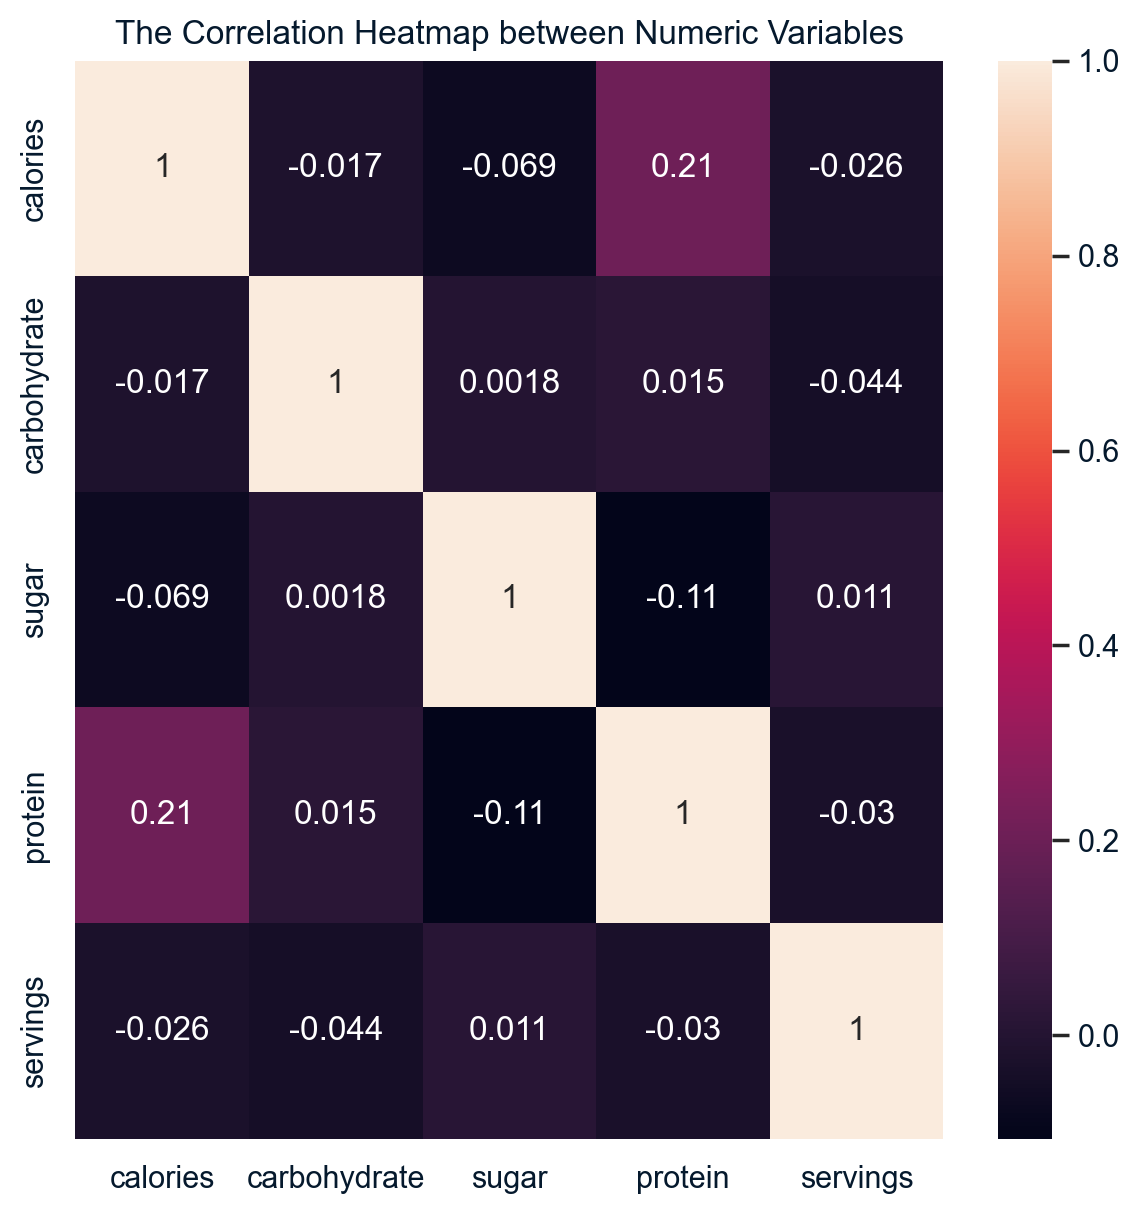

In [9]:
#Correlation between numeric values (sns.heatmap)
sns.set(rc = {'figure.figsize':(7,7)})
numeric = cleaned_df[['calories','carbohydrate','sugar','protein', 'servings']]
sns.heatmap(numeric.corr(method='spearman'),annot=True).set(title='The Correlation Heatmap between Numeric Variables')
plt.show()

In the analysis of the 'high_traffic' column and the 'category' feature, the following points summarize the key observations and implications:

Target Variable ('high_traffic') Distribution 
- Distribution Overview (Fig.4, left plot):
The 'high_traffic' column contains 574 'High' values and 373 'Unknown' values.
This results in a percentage distribution of approximately 60.6% for 'High' and 39.4% for 'Unknown'.
- Class Imbalance:
The difference between the two classes is 21.2%, which indicates a moderate class imbalance. Ideally, a balanced dataset has class proportions close to each other, with a difference of no more than 10-20%.
Impact on Predictive Models: Imbalance can lead to models being biased towards the majority class ('High' in this case). This can affect the model’s performance on the minority class ('Unknown'), making it less effective at predicting or classifying the less frequent class.
- Performance Metrics:
For imbalanced datasets, metrics such as precision, recall, F1-score, and AUC-ROC are preferred over accuracy. These metrics provide a better understanding of how well the model performs on both classes, especially the minority class.

Category Feature Distribution
- Distribution Overview (Fig. 4, right plot):
The 'category' feature shows the highest number of recipes in the 'Chicken' group, with 172 out of 947 total values. The 'One Dish Meal' group has the lowest number of recipes, with 71 out of 947 total values.
- Implications for Analysis:
Understanding the distribution of categories is crucial for feature engineering and model training. A higher number of recipes in certain categories might influence the predictive model, particularly if the model relies on categorical features.

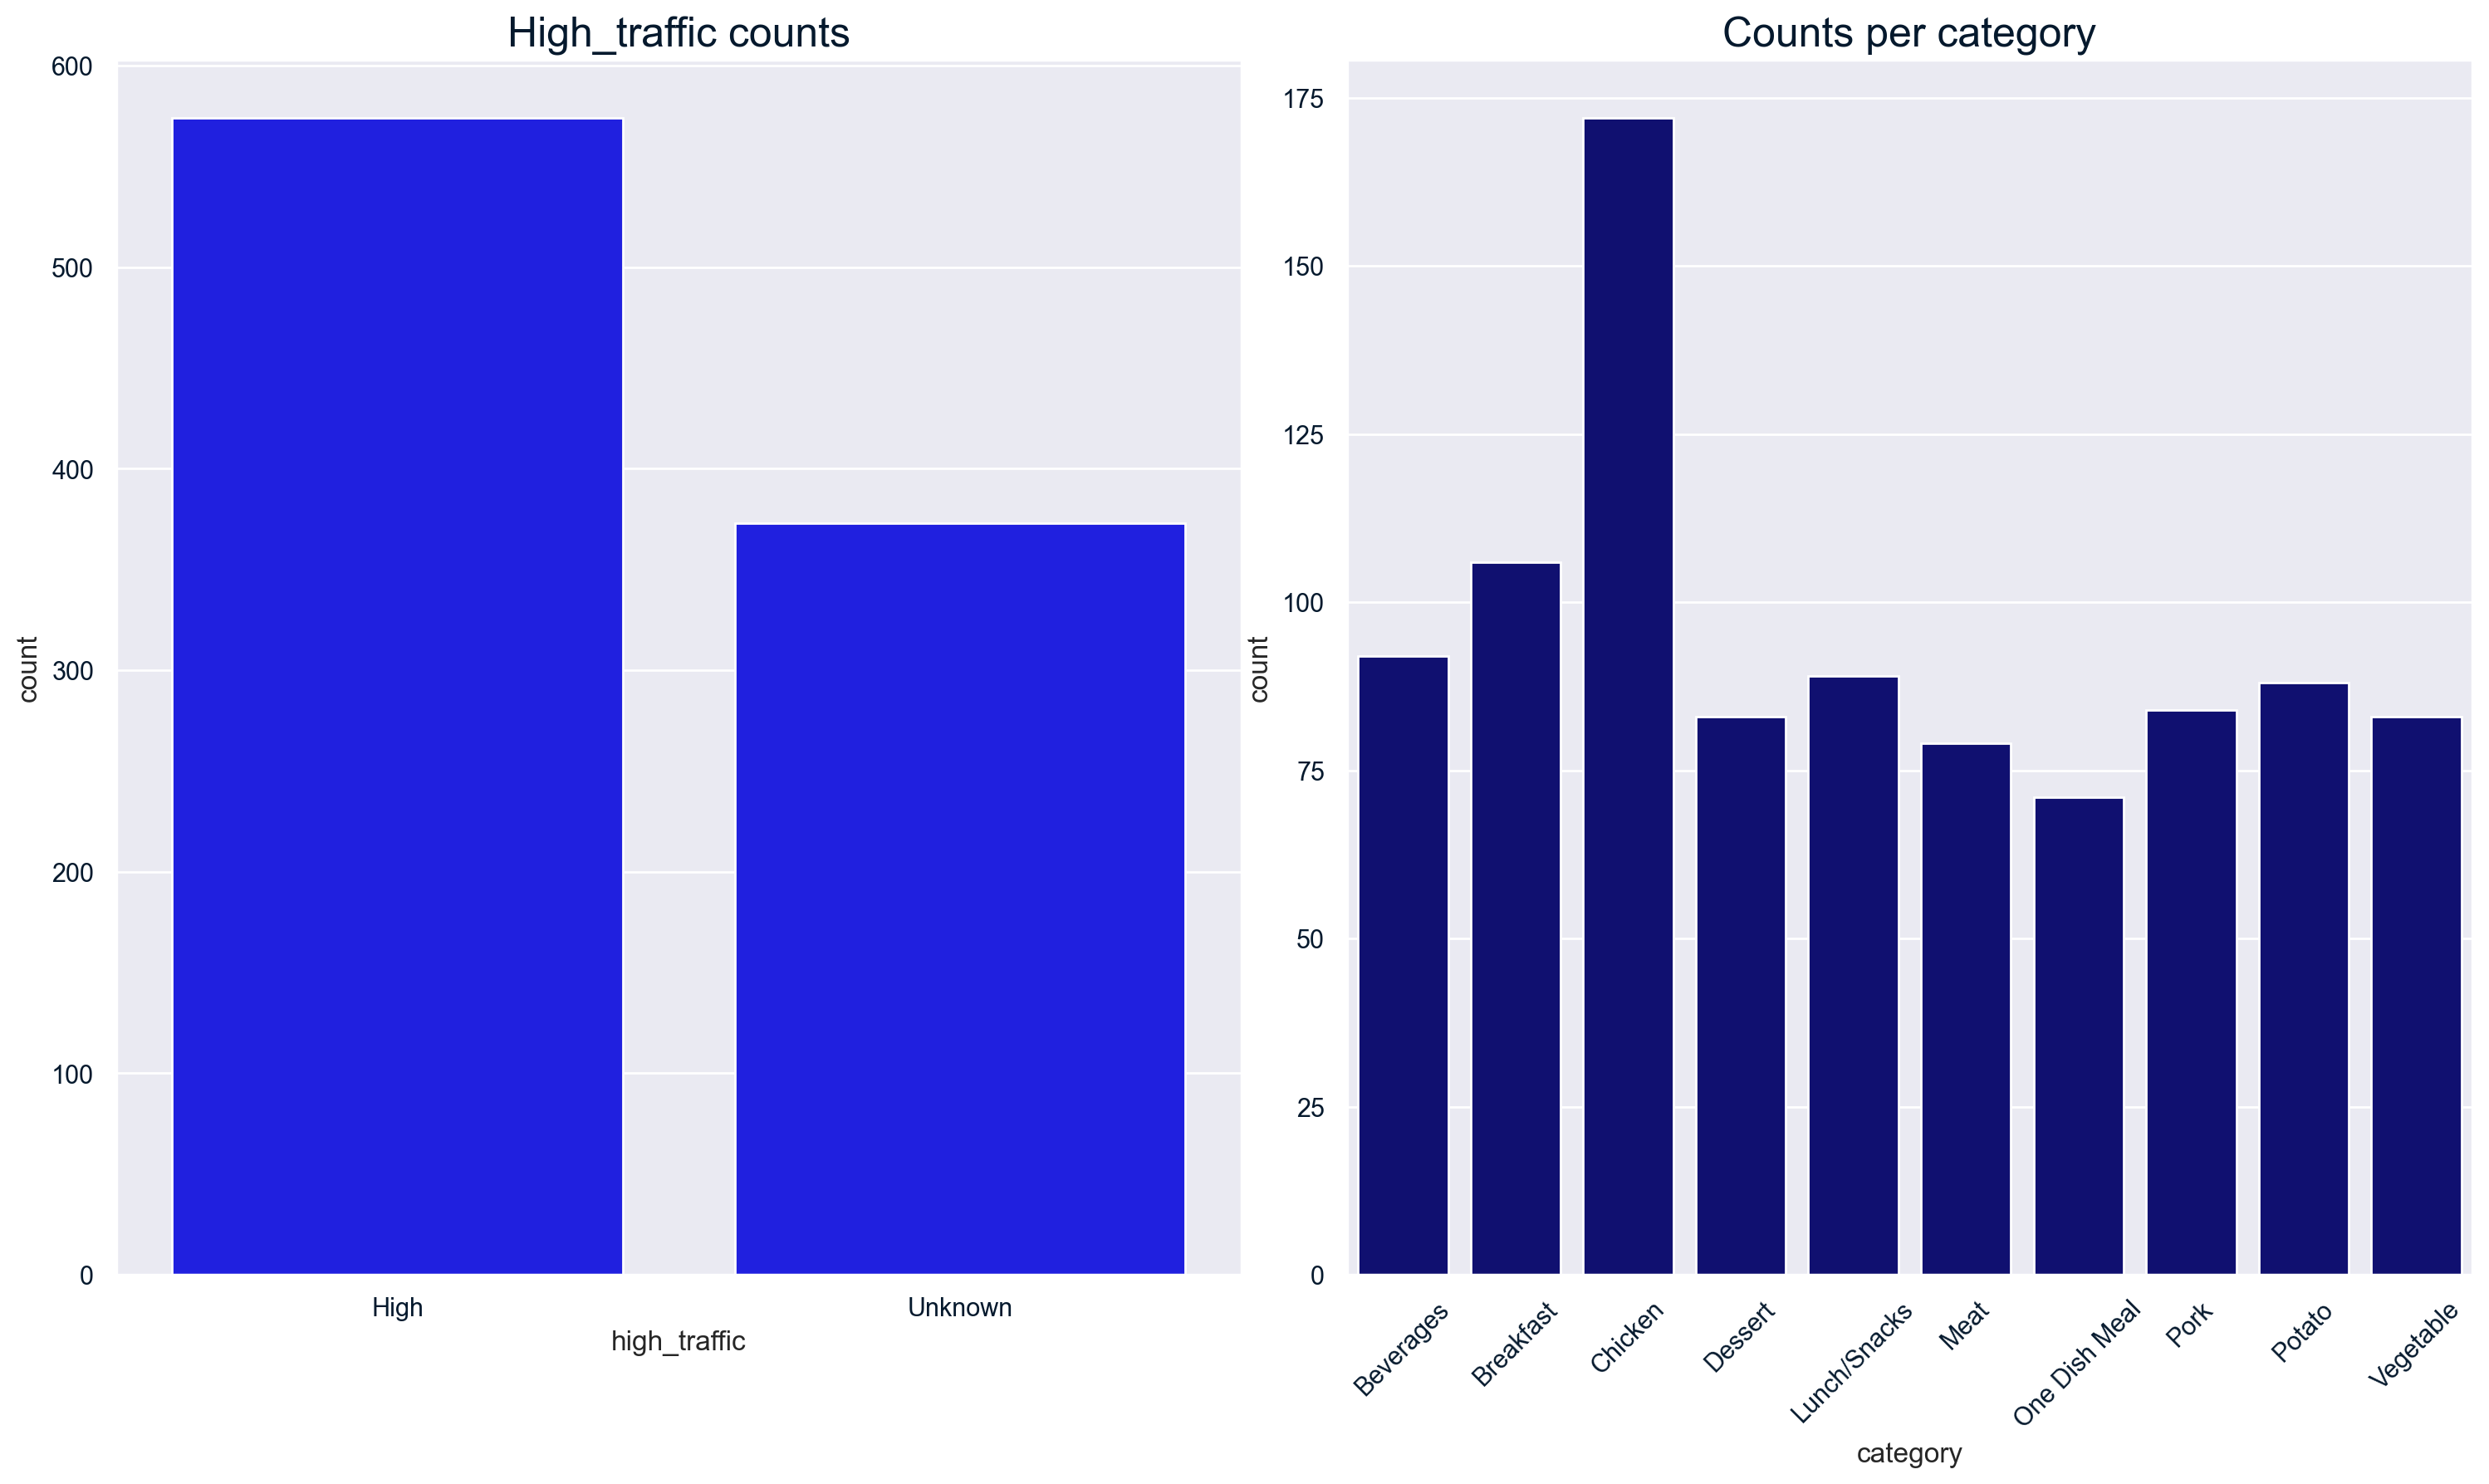

In [10]:
#Visualization of categorical variables (sns.countplot for 'high_traffic' and 'category' columns) 
fig, axes = plt.subplots(1,2,figsize=(15,8))
plt.tight_layout()
sns.countplot(x=cleaned_df['high_traffic'], color='blue',ax=axes[0])
axes[0].set_title('High_traffic counts', fontsize=18)
axes[0].tick_params(axis='x', labelrotation=0)
sns.countplot(x=cleaned_df['category'], color='navy',ax=axes[1])
axes[1].set_title('Counts per category', fontsize=18)
axes[1].tick_params(axis='x', labelrotation=45)

In Fig. 5, the stacked bar plot illustrates the distribution of recipes between 'High' traffic and 'Unknown' traffic across different categories. The plot highlights several key observations:
- 'Vegetable' Group: This category has an exceptionally high concentration of 'High' traffic recipes, with 82 out of 83 recipes falling into this category, which is approximately 99%. This indicates that almost all vegetable recipes are associated with high traffic.
- 'Potato' Group: Similarly, the 'Potato' group also shows a significant proportion of high traffic, with 83 out of 88 recipes categorized as 'High' traffic, translating to about 94%.
- 'Pork' Group: The 'Pork' category has 77 out of 84 recipes classified as 'High' traffic, representing around 92%.
- 'Beverages' Group: In contrast, the 'Beverages' category shows the lowest proportion of high traffic, with only 5 out of 92 recipes in this category, which is about 5.4%.
These findings reveal that recipes from the 'Vegetable', 'Potato', and 'Pork' groups are strongly associated with high traffic, with each group showing high traffic in over 90% of cases. On the other hand, recipes in the 'Beverages' group are predominantly associated with 'Unknown' traffic, indicating much lower visibility or engagement. 

This distribution highlights the importance of focusing on categories like 'Vegetable', 'Potato', and 'Pork' to maximize high traffic.

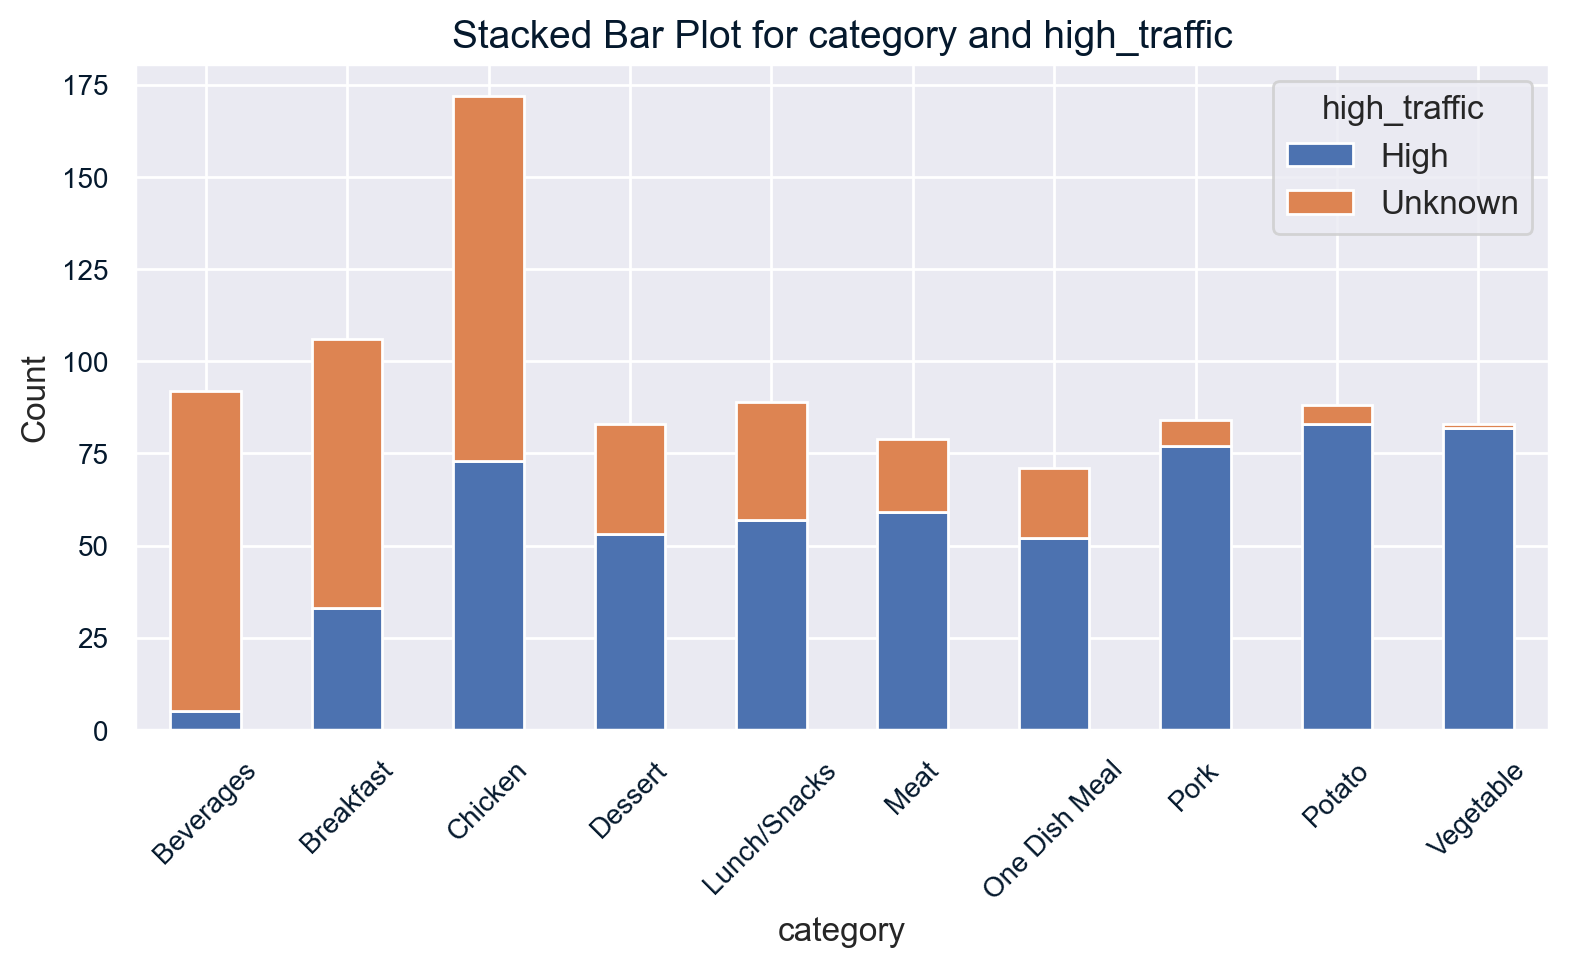

In [11]:
# Stacked bar plot for 'category' and 'high_traffic' value counts.
def stacked_barplot(df, categorical_column1, categorical_column2):
    """The function creates a stacked countplot for a categorical column, based on another categorical column values"""
    # Create a pivot table
    pivot_table = df.pivot_table(index=categorical_column1, columns=categorical_column2, aggfunc='size')
    # Plotting the stacked bar plot
    pivot_table.plot(kind='bar', stacked=True, figsize=(8, 5))
    # Adding labels and title
    plt.xlabel(categorical_column1, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f"Stacked Bar Plot for {categorical_column1} and {categorical_column2}", fontsize=14)
    plt.legend(title=categorical_column2, fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

categorical_column1 = 'category'  
categorical_column2 = 'high_traffic'
stacked_barplot(cleaned_df, categorical_column1, categorical_column2)

In Fig. 6, the barplots comparing median values for 'High' traffic versus 'Unknown' traffic reveal several patterns across different category groups:
Among the 'High' traffic categories ('Vegetable', 'Potato', and 'Pork'):
- Calories:  only the 'Vegetable' group showed higher median values of calories compared to the 'Unknown' traffic group.
- Carbohydrates: Similarly, only 'Vegetable' and 'Potato' groups have higher median carbohydrate values for 'High' traffic compared to the 'Unknown' traffic group.
- Sugar: Only the 'Vegetable' group have higher median sugar values for 'High' traffic compared to the 'Unknown' traffic group.
- Protein: The 'Potato' group stands out with higher median protein values for 'High' traffic relative to the 'Unknown' traffic group.
- Servings: Only the 'Potato' group exhibits higher median values for servings in the 'High' traffic category compared to the 'Unknown' traffic group.

These observations suggest that different factors might contribute to high traffic depending on the category group. For example, the 'Vegetable' category appears to have higher median values for calories, carbohydrate and sugar in high traffic cases, while 'Potato' category group has higher carbohydrate, protein and servings median values in comparison with the 'Unknown' traffic cases. This indicates that the factors influencing high traffic can vary across categories, suggesting that a nuanced approach might be needed when predicting high traffic recipes based on their nutritional attributes.

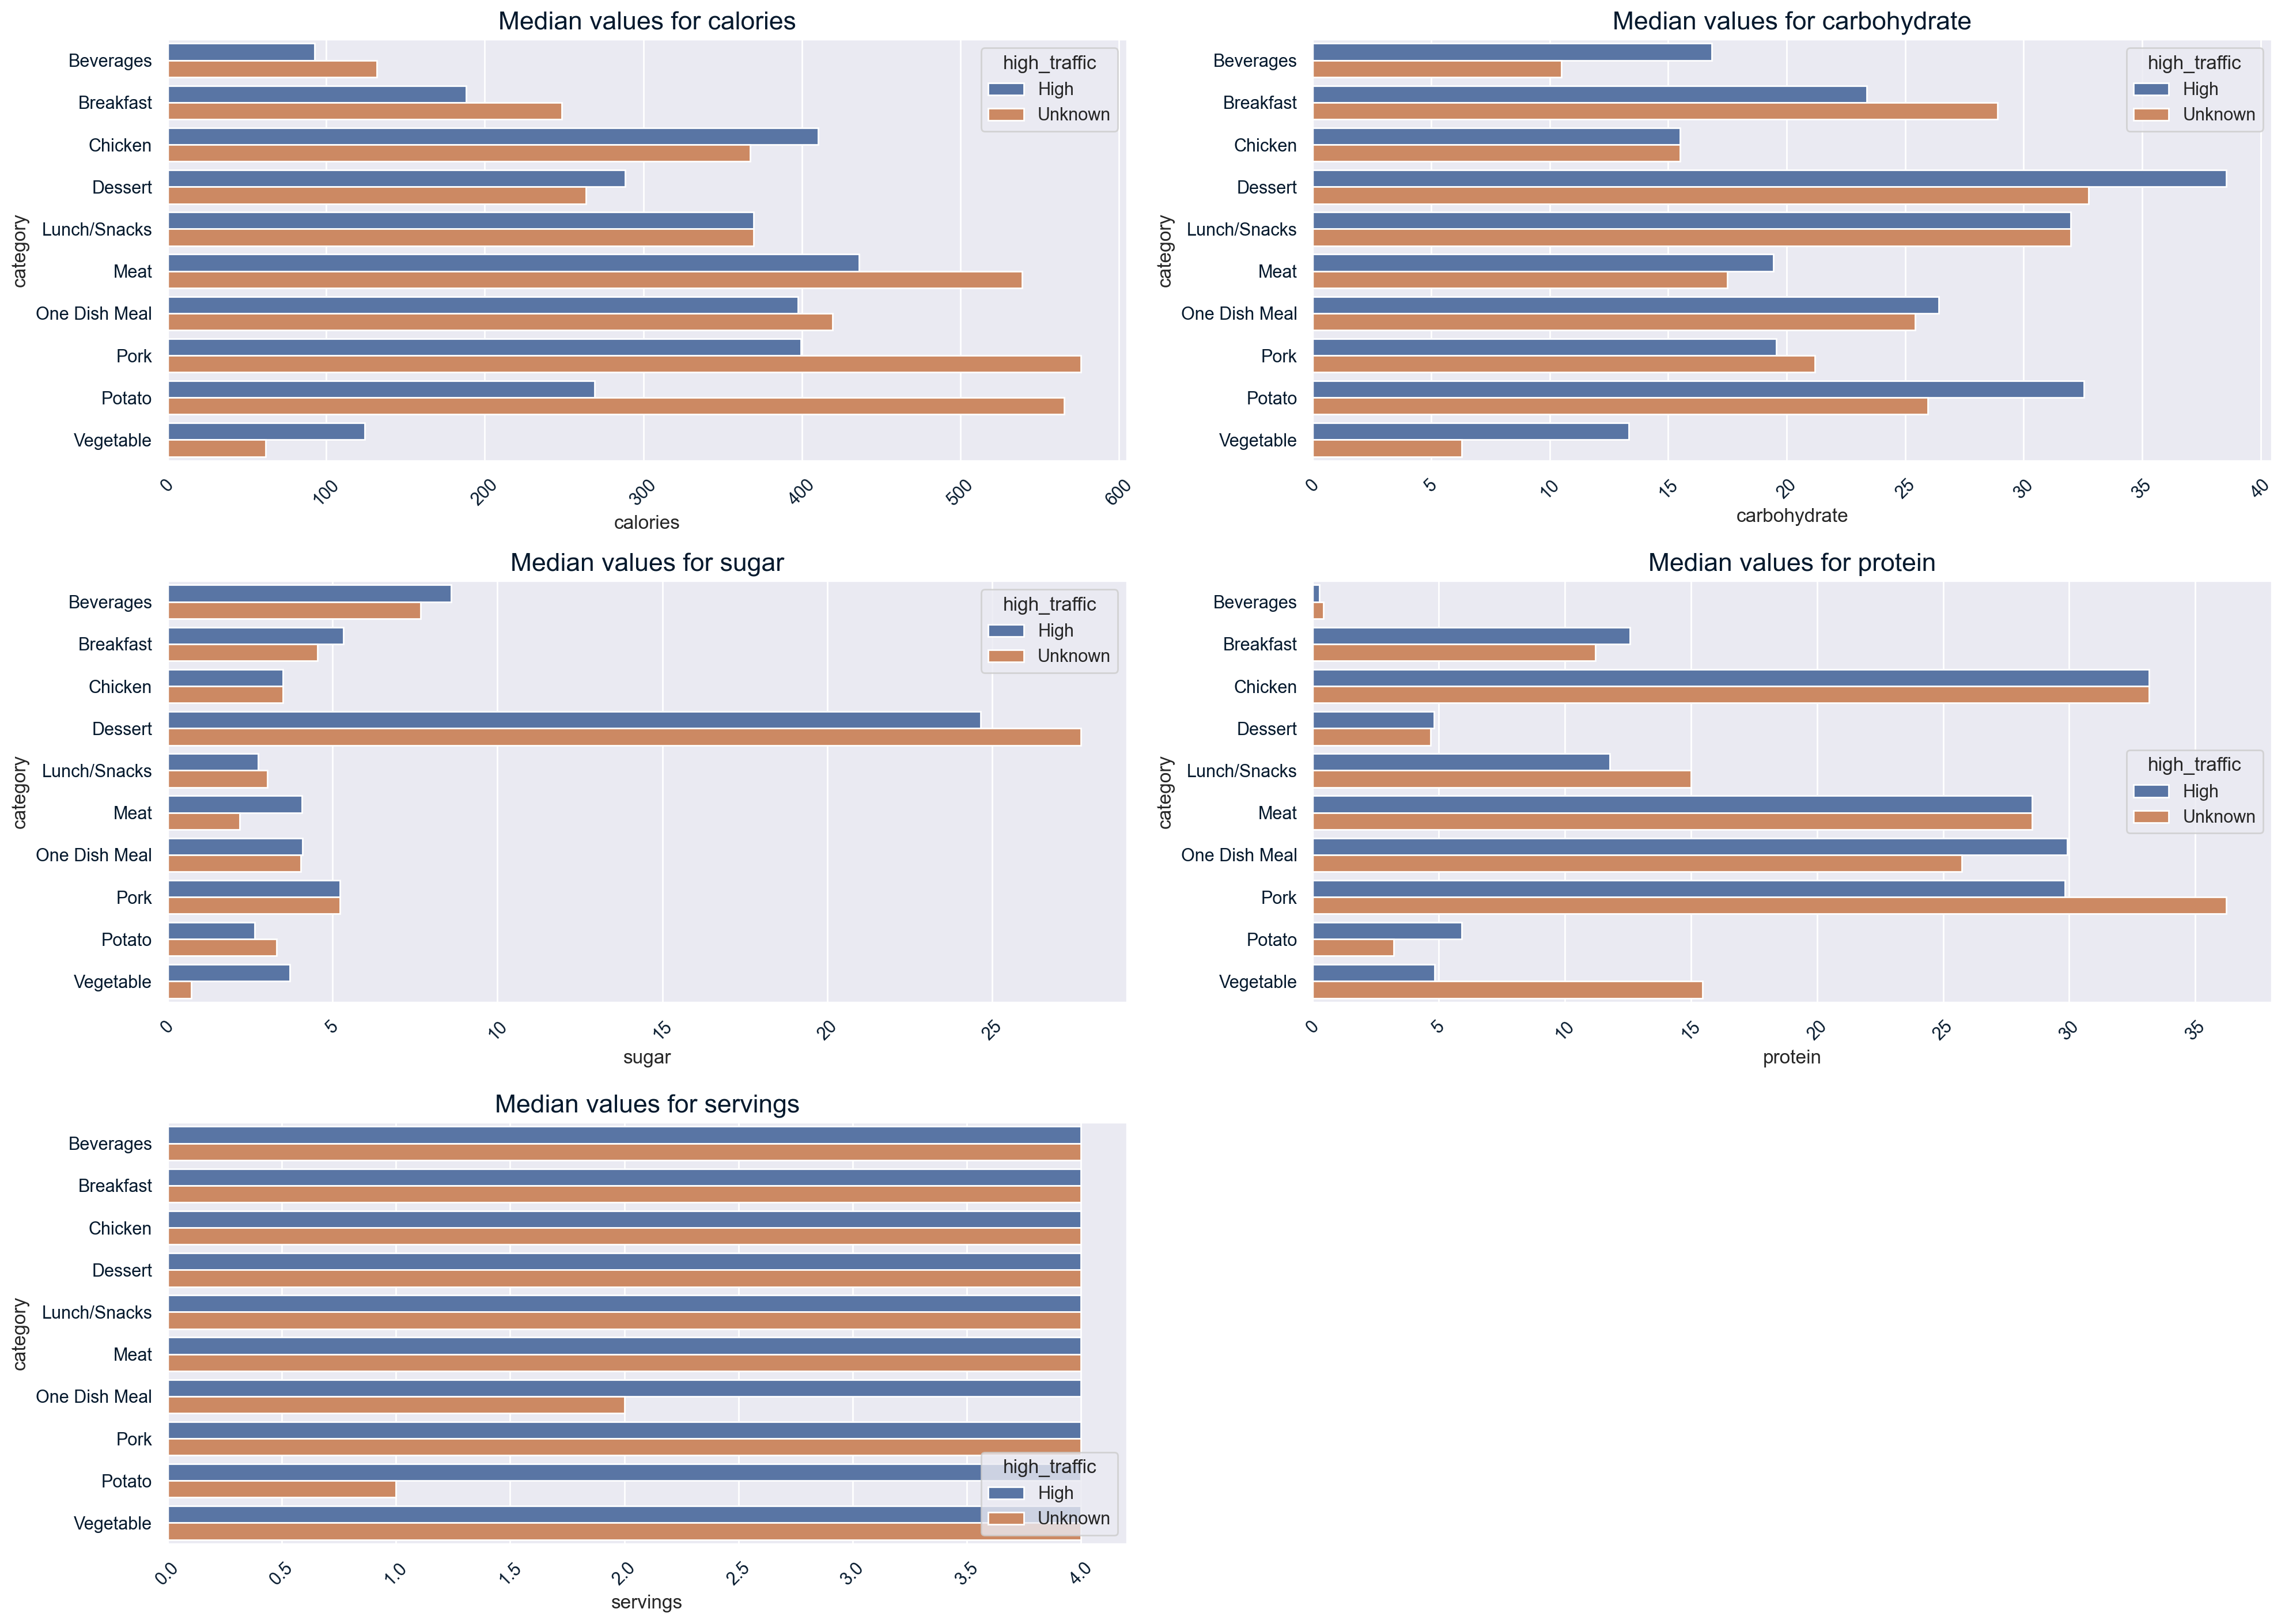

"High" traffic value counts for each category:
Potato           83
Vegetable        82
Pork             77
Chicken          73
Meat             59
Lunch/Snacks     57
Dessert          53
One Dish Meal    52
Breakfast        33
Beverages         5
Name: category, dtype: int64
"Unknown" traffic value counts for each category:
Chicken          99
Beverages        87
Breakfast        73
Lunch/Snacks     32
Dessert          30
Meat             20
One Dish Meal    19
Pork              7
Potato            5
Vegetable         1
Name: category, dtype: int64


In [12]:
traffic_df = cleaned_df.groupby(['category', 'high_traffic'])['calories', 'carbohydrate', 'sugar', 'protein', 'servings'].median()

#Visualization of categorical variables (sns.barplots) based on numerical columns value for each category in 'category' column)
def plot_barplots(df, x_columns, y_column, hue_column, figsize=(20, 15)):
    """The  function creates series of seaborn barplots for a categorical column (y-axis) using the data of numerical columns(x-axis)"""
    # Check if the DataFrame is empty
    if df.empty:
        raise ValueError("The DataFrame is empty.")
    # Check if the columns are in the DataFrame
    for col in x_columns:
        if col not in df.columns:
            raise ValueError(f"Column {col} is not in the DataFrame.")

    # Number of columns and rows in the subplot grid
    n = len(x_columns)
    ncols = 2
    nrows = (n + ncols - 1) // ncols  
    # Create the subplot grid
    sns.color_palette("Paired")
    plt.figure(figsize=figsize)
    for i, col in enumerate(x_columns):
        plt.subplot(nrows, ncols, i + 1)
        sns.barplot(data=df, x=col, y=y_column, hue=hue_column)
        plt.title(f"Median values for {col}", fontsize=16)
        plt.xticks(rotation=45) 
    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to accommodate suptitle
    # Show the plot
    plt.show()

hue_column = 'high_traffic'    
x_columns = ['calories','carbohydrate', 'sugar', 'protein', 'servings']
y_column = 'category'
plot_barplots(traffic_df, x_columns, y_column, hue_column)

#counting 'High' and 'Unknown' traffic values in 'category' column
cleaned_df_high = cleaned_df.loc[cleaned_df['high_traffic']=='High']
print('"High" traffic value counts for each category:')
print(cleaned_df_high['category'].value_counts())
cleaned_df_unknown = cleaned_df.loc[cleaned_df['high_traffic']=='Unknown']
print('"Unknown" traffic value counts for each category:')
print(cleaned_df_unknown['category'].value_counts())


The scatterplots in Fig. 7 (see below) illustrate the distribution of numerical variables ('calories', 'carbohydrate', 'sugar', and 'protein') across different categories in the 'category' column, with traffic types ('High' and 'Unknown') indicated by color (blue and orange) and serving sizes depicted by circle size. The analysis suggests that there is no straightforward correlation between these numerical variables and high traffic.
To generalize and optimize traffic across all categories, a predictive model could be developed. Such a model would analyze the attributes of recipes and predict their potential to generate high traffic, thus helping to identify successful recipes across different category groups.

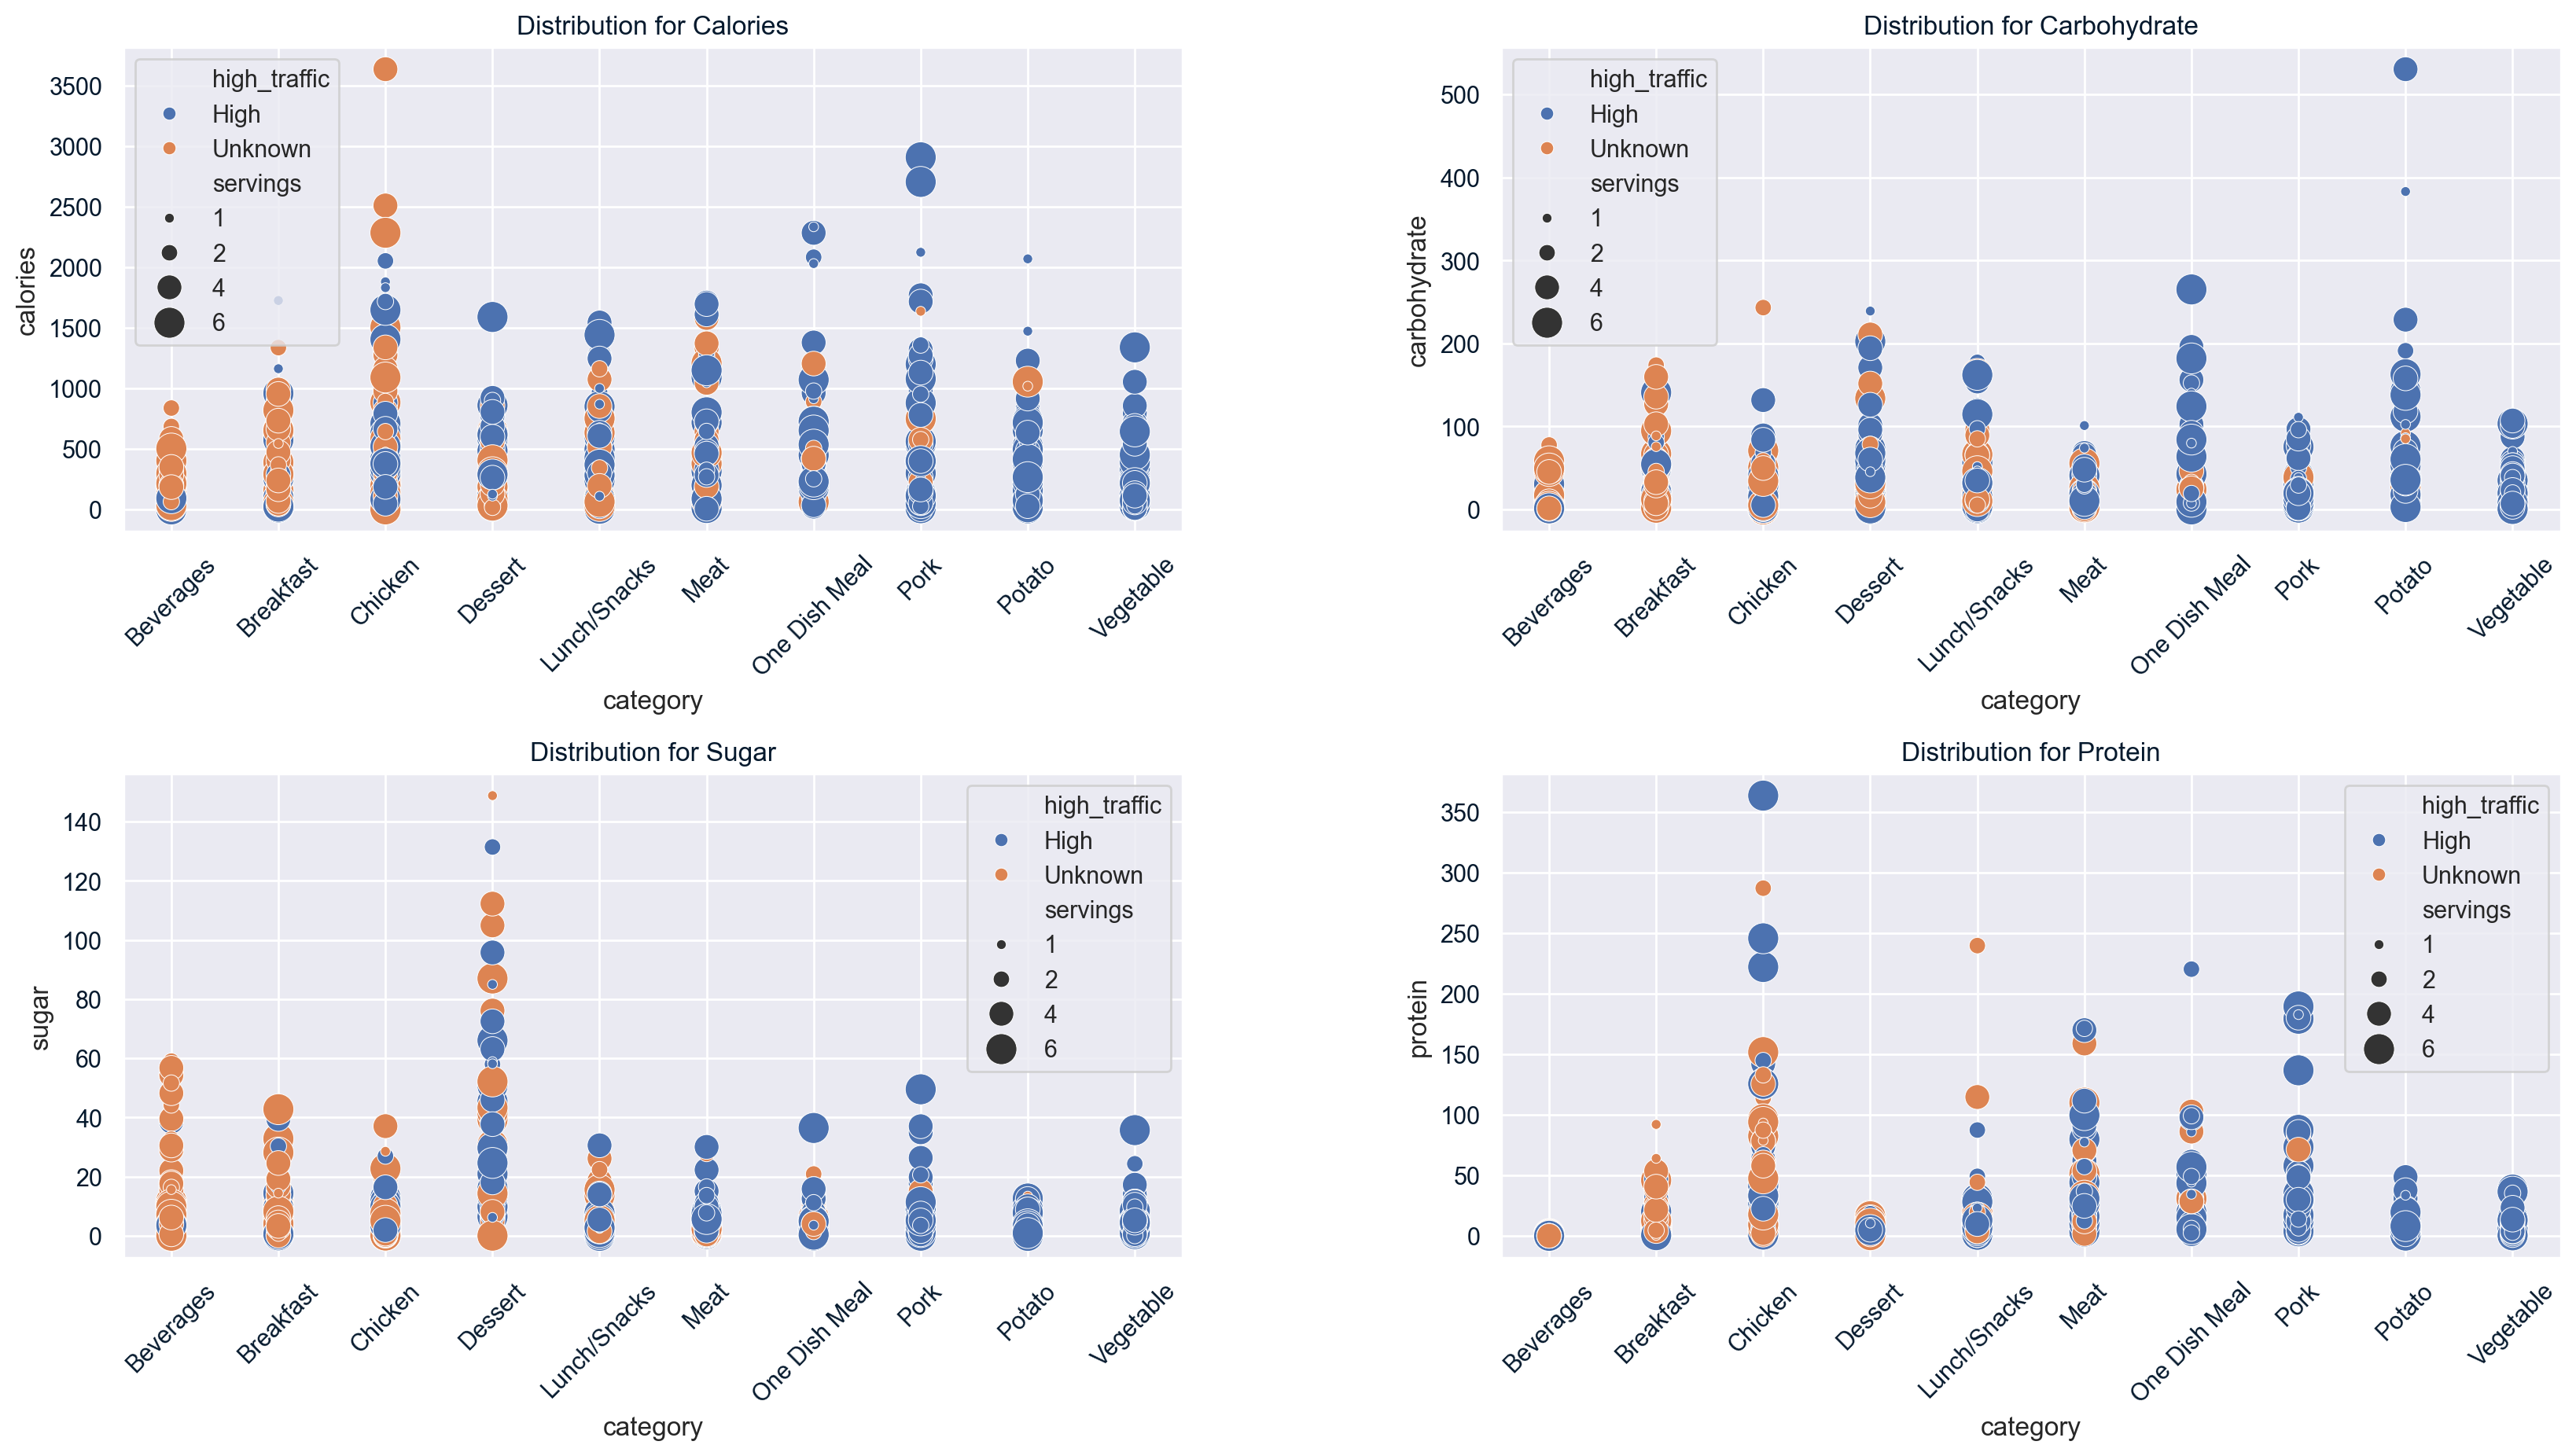

In [13]:
#Visualization of numerical and categorical variables (sns.scatterplots for numerical columns of 'float' data type for each category in 'category' column with the color mapped to 'high_traffic' column and size mapped to 'servings' column)
fig, axes = plt.subplots(2,2,figsize=(20,10))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
sns.scatterplot(data=cleaned_df, y='calories',x='category',hue='high_traffic', size='servings', sizes=(20, 200), ax=axes[0,0]).set(title='Distribution for Calories')
sns.scatterplot(data=cleaned_df, y='carbohydrate',x='category',hue='high_traffic', size='servings', sizes=(20, 200), ax=axes[0,1]).set(title='Distribution for Carbohydrate')
sns.scatterplot(data=cleaned_df, y='sugar',x='category',hue='high_traffic', size='servings', sizes=(20, 200), ax=axes[1,0]).set(title='Distribution for Sugar')
sns.scatterplot(data=cleaned_df, y='protein',x='category',hue='high_traffic', size='servings', sizes=(20, 200), ax=axes[1,1]).set(title='Distribution for Protein')
axes[0,0].tick_params(axis='x', labelrotation=45)
axes[0,1].tick_params(axis='x', labelrotation=45)
axes[1,0].tick_params(axis='x', labelrotation=45)
axes[1,1].tick_params(axis='x', labelrotation=45)
plt.show()

Before creating predictive models we need to encode the categorical variables ('high_traffic' and 'category'). Since the aim of the present study is to predict the recipes with high traffic, our target variable is the 'high_traffic' column. I replaced 'High' and 'Unknown' groups of 'high_traffic' column with '1' and '0', respectively, and changed the data type of the column to dtype='int'.
I used pandas.get_dummies() to encode the groups in 'category' column.

In [14]:
new_df = cleaned_df
print(new_df.info())

#Categorical column 'high_traffic' encoding. 
new_df['high_traffic'] = new_df['high_traffic'].str.replace('High', '1')
new_df['high_traffic'] = new_df['high_traffic'].str.replace('Unknown', '0')
new_df['high_traffic'] = new_df['high_traffic'].astype('int')

#Categorical column 'category' encoding.
new_df = pd.get_dummies(new_df, columns=['category'])
print(new_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   recipe            947 non-null    int64   
 1   calories          947 non-null    float64 
 2   carbohydrate      947 non-null    float64 
 3   sugar             947 non-null    float64 
 4   protein           947 non-null    float64 
 5   category          947 non-null    category
 6   servings          947 non-null    int64   
 7   high_traffic      947 non-null    object  
 8   calories_log      947 non-null    float64 
 9   carbohydrate_log  947 non-null    float64 
 10  sugar_log         947 non-null    float64 
 11  protein_log       947 non-null    float64 
dtypes: category(1), float64(8), int64(2), object(1)
memory usage: 82.8+ KB
None
   recipe  calories  carbohydrate  sugar  protein  servings  high_traffic  \
0       1    399.26         19.56   5.23    29.82         6      

As I mentioned above, our target variable (y) is 'high_traffic' column. The features (X) include all columns except 'recipe', 'high_traffic', and the numerical columns that were not log_transformed ('calories', 'carbohydrate', 'sugar' and 'protein'). After choosing features and target variables, I splitted the dataset into train and test sets with an 80% training set size. 

In [15]:
#Spliting the dataset into train and test
X = new_df.drop(['recipe', 'high_traffic', 'calories', 'carbohydrate', 'sugar', 'protein'], axis = 1).values
y = new_df['high_traffic'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8,  random_state=123)

The first machine learning model for binary classification I choose is Logistic Regression.
For the model evaluation I used the following metrics: Accuracy, Precision, Recall, F1-score, and AUC-ROC score. 

In [16]:
#Creating the 1st Model - LogisticRegression
model=LogisticRegression(random_state=42)
#Training the model on the train set
model.fit(X_train, y_train)
# Evaluate the model on the test set
y_pred = model.predict(X_test)
print('_________________________')
print('Logisticregression:')
# Evaluate the model
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification report:')
print(classification_report(y_test, y_pred))

_________________________
Logisticregression:
Accuracy:  0.7894736842105263
Confusion matrix:
[[51 24]
 [16 99]]
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        75
           1       0.80      0.86      0.83       115

    accuracy                           0.79       190
   macro avg       0.78      0.77      0.78       190
weighted avg       0.79      0.79      0.79       190



The results indicate that the Logistic Regression model is performing reasonably well.
The data for the Precision, Recall, and F1-Score for Class 1 suggest the following:
- Precision (0.80): Out of all the instances predicted as class 1, 80% are actually class 1. This indicates a good proportion of positive predictions are correct.
- Recall (0.86): Of all actual class 1 instances, 86% were correctly identified by the model. This shows the model's ability to capture most of the positives.
- F1-Score (0.83): This is the harmonic mean of precision and recall. An F1-score of 0.83 indicates a good balance between precision and recall for class 1.
- Accuracy (0.79): This is the proportion of correctly predicted instances (both class 0 and class 1) out of the total instances. An accuracy of 0.79 means the model correctly predicted 79% of the instances overall.

As a comparison machine learning model for binary classification I choose Random Forest Classifier.
For the model evaluation I used the same metrics: Accuracy, Precision, Recall, F1-score, and AUC-ROC score. 
To find the best performing model, I used GridSearchCV for the  hyperparameter tuning.

In [17]:
#Creating 2d model - RandomForestClassifier
print('RandomForestClassifier:')

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
#Creating grid_search parameters for the model tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
# Initialize GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=10)
# Train the model
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

# Make predictions on the test set
y_pred_grid = grid_search.predict(X_test)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_
print(f'Best estimator: {best_rf_model}')

RandomForestClassifier:
Best parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best estimator: RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=50, random_state=42)


The results indicate that the Best estimator is RandomForestClassifier with max_depth=10, max_features='auto', min_samples_leaf=2, min_samples_split=5 and n_estimators=50.
The most important feature was 'protein_log' column and the least important was 'category_Dessert' column.

In [18]:
# Get feature importances from the best model
train_test_X_df = new_df.drop(['recipe', 'high_traffic', 'calories', 'carbohydrate', 'sugar', 'protein'], axis = 1)
# Get feature importances from the best model
def print_feature_importances(model, df):
    """The function prints feature_importances for the features in train/test dataset."""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = df.columns
        sorted_indices = np.argsort(importances)[::-1]

        print("Feature importances:")
        for idx in sorted_indices:
            print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    else:
        print("The model does not have feature importances.")
        
print_feature_importances(best_rf_model, train_test_X_df)

Feature importances:
protein_log: 0.1820
category_Beverages: 0.1298
calories_log: 0.1143
sugar_log: 0.1130
carbohydrate_log: 0.1098
category_Chicken: 0.0698
category_Vegetable: 0.0659
category_Breakfast: 0.0659
category_Potato: 0.0589
servings: 0.0400
category_Pork: 0.0291
category_Lunch/Snacks: 0.0070
category_One Dish Meal: 0.0059
category_Meat: 0.0046
category_Dessert: 0.0040


The RandomForestClassifier with the best parameters from GridSearchCV has shown promising results. 
- Precision (0.80): This means 80% of the instances predicted as class 1 are actually class 1. This is similar to the Logistic Regression model, indicating that the proportion of correct positive predictions is consistent.
- Recall (0.90): The model identified 90% of all actual class 1 instances. This is an improvement over the Logistic Regression model (0.86 recall), showing better performance in capturing positive cases.
- F1-Score (0.85): The harmonic mean of precision and recall for class 1 is higher than in the Logistic Regression model (0.83), reflecting a better balance between precision and recall.
- Accuracy (0.81): The accuracy of 0.81 is better than the 0.79 achieved with the Logistic Regression model, indicating an overall improvement in classification performance.

In [22]:
best_params = grid_search.best_params_

# Initialize a new RandomForestClassifier with the best parameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42)

# Train the model with the best parameters on the entire training set
best_rf_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)

# Print the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.8052631578947368
Confusion Matrix:
[[ 50  25]
 [ 12 103]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        75
           1       0.80      0.90      0.85       115

    accuracy                           0.81       190
   macro avg       0.81      0.78      0.79       190
weighted avg       0.81      0.81      0.80       190



To see how well both models are distinguishing between the high traffic and low traffic recipes I plotted the Receiver Operating Characteristic (ROC) curve plots and calculated ROC_AUC score that provides the model's ability to distinguish between positive and negative classes. 

Both model showed ROC_AUC score of 0.87 that indicates that both models have a high capability to correctly classify positive and negative instances. A ROC-AUC score of 0.87 is generally considered excellent, indicating that the models have strong predictive power. 

In practical terms, this means that the models are effective in ranking the instances by their predicted probability of being in the positive class.

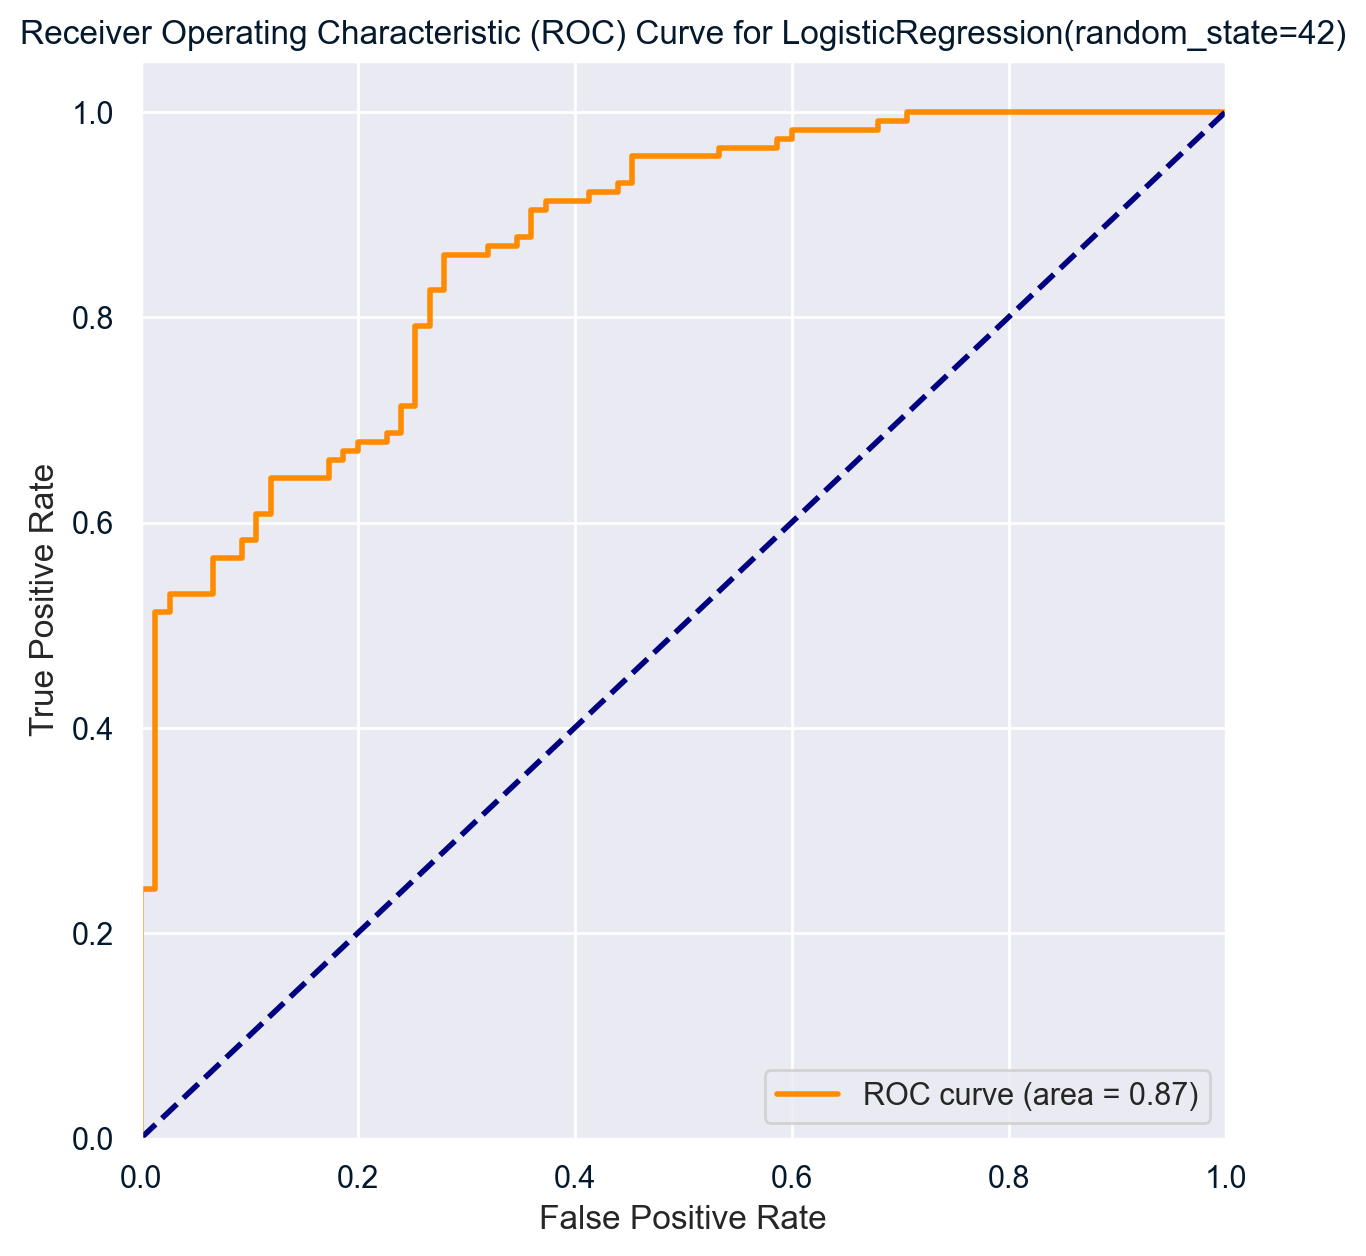

ROC-AUC Score: 0.87


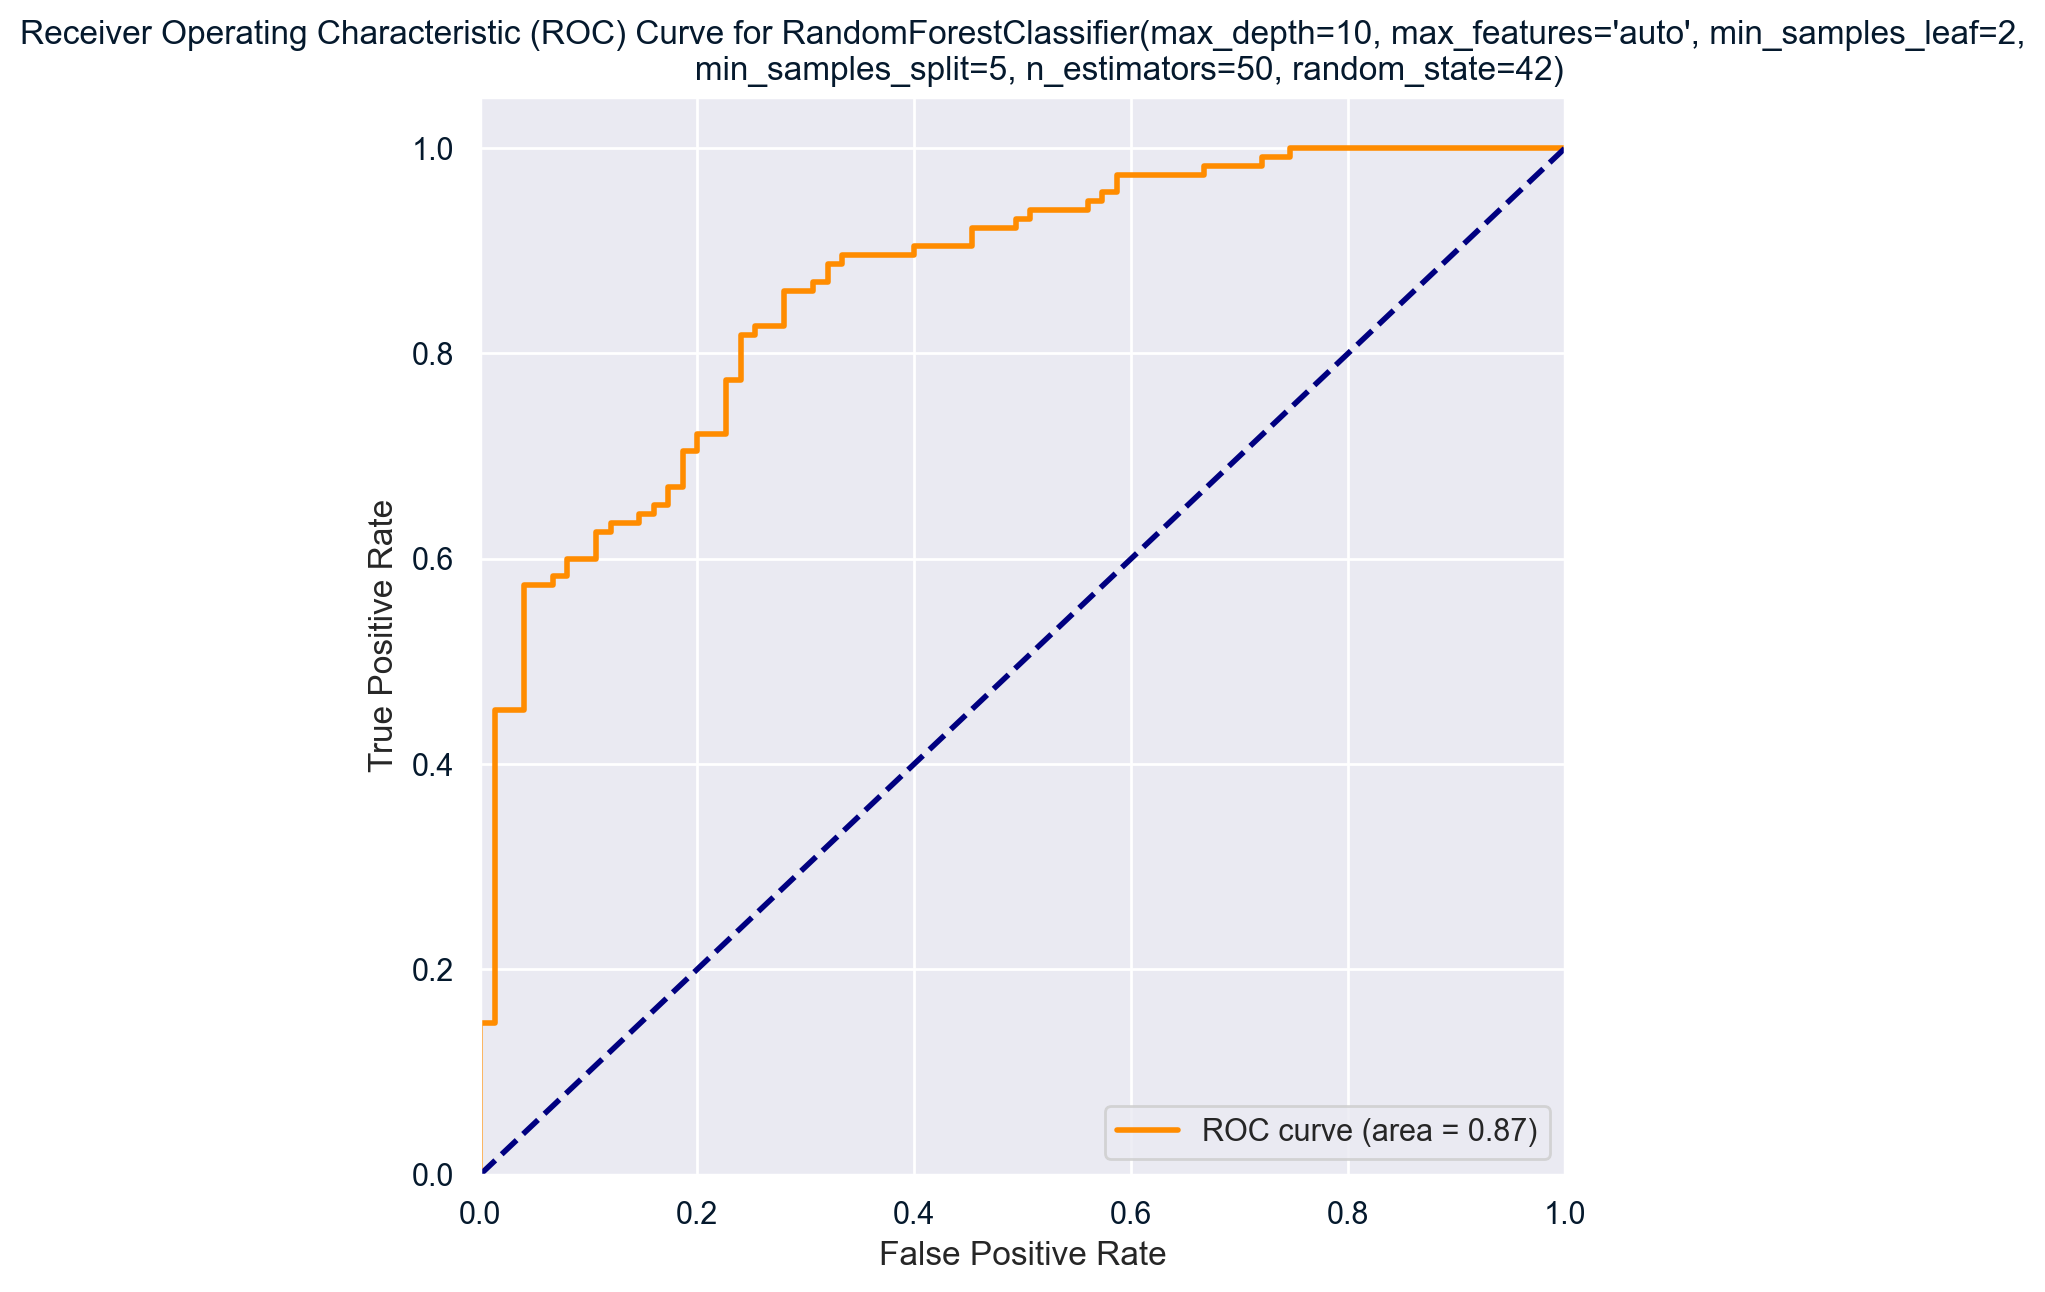

ROC-AUC Score: 0.87


In [20]:
#Visualization of roc_auc_curve for models
def roc_auc_curve(models, X_test, y_test):
    """The function plots Receiver Operating Characteristic (ROC) Curve for choosen models and prints ROC-AUC score."""
    for model in models:
        # Predict probabilities on the test data
        y_proba = model.predict_proba(X_test)[:, 1]
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        # Calculate ROC-AUC score
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model}')
        plt.legend(loc='lower right')
        plt.show()
        # Print ROC-AUC score
        print(f'ROC-AUC Score: {roc_auc:.2f}')
        
models = [model, best_rf_model]
roc_auc_curve(models, X_test, y_test)

Based on the business goal of increasing the number of subscriptions by showcasing recipes that drive higher traffic,
the low number of False Negatives (FN, when the model fails to predict high traffic that actually is the case) is more important than low number of False Positives (FP, when the model predicts high traffic that is not actually the case)

For business high number of FN would result in:
- Missed Opportunities: Failing to identify high-traffic recipes means missing out on potential opportunities to increase traffic, engagement, and revenue. This can directly impact subscriptions,  revenue and growth.
- Competitive Disadvantage: Not leveraging high-traffic opportunities effectively can put Tasty Bites company at a competitive disadvantage, especially if competitors are better at identifying and promoting high-value content.

Taking into account the considerations mentioned above, I recommend to use False Negative Rate (FNR), the proportion of actual positives (high-traffic recipes) that were incorrectly predicted as negatives (low-traffic recipes). It shows how often high-traffic recipes are missed by the model, as business KPI.

To calculate this KPI, use the following formula:

False Negative Rate (FNR) = False Nagatives (FN)/
                     (False Negatives (FN) + True Positives (TP))
                                   
Low FNR indicates that the model is effective at identifying positive cases, which aligns with the goal of minimizing missed high-traffic opportunities.

To find FP, and FN the confusion_matrix() for LogisticRegression and RandomForestClassifier models can be used.

The results show that the RandomForestClassifier model has lower FNR in comparison with the LogisticRegression model (0.10 vs. 0.14, respectively). 

Logistic Regression (FNR = 0.14):
Indicates that 14% of the actual high-traffic recipes are missed by the model. This relatively higher FNR means more high-traffic recipes are not identified, leading to missed opportunities for engagement and revenue.

Random Forest Classifier (FNR = 0.10):
Indicates that 10% of the actual high-traffic recipes are missed by the model. This lower FNR means fewer high-traffic recipes are missed, better aligning with the goal of minimizing missed opportunities and increasing subscriptions.

In [21]:
#False Negative Rate (FNR) for Logistic Regression
lr_fnr = confusion_matrix(y_test, y_pred)[1,0]/(confusion_matrix(y_test, y_pred)[1,0] + confusion_matrix(y_test, y_pred)[1,1])

#False Negative Rate (FNR) for Logistic Regression
rf_fnr = confusion_matrix(y_test, y_pred_rf)[1,0]/(confusion_matrix(y_test, y_pred_rf)[1,0] + confusion_matrix(y_test, y_pred_rf)[1,1])
                                               
metrics_df = pd.DataFrame({'estimator':['LogisticRegression', 'RandomForestClassifier'], 'False Negative Rate (FNR)':[lr_fnr, rf_fnr]})                                                 
metrics_df = metrics_df.set_index('estimator').round(2)

print(metrics_df)

                        False Negative Rate (FNR)
estimator                                        
LogisticRegression                           0.14
RandomForestClassifier                       0.10


## Summary`
The **Random Forest Classifier** is better suited for the business goal due to its higher recall, F1-score, and lower FNR, which aligns with the business objective of effectively identifying high-traffic recipes.

### Recommended Implementation Plan:
- Real-Time Monitoring: Develop a dashboard that visualizes the False Negative Rate (FNR) in real-time. Include metrics such as the number of high-traffic recipes missed, and overall performance trends.
- Threshold Alerts: Implement alerts to notify the team when the FNR exceeds predefined thresholds. This will help in quickly identifying and addressing issues related to missed high-traffic recipes.
- Hyperparameter Tuning: Regularly review and retune hyperparameters as new recipes are added to the dataset. This will help maintain optimal performance of the Random Forest Classifier.
- User Engagement: Implement mechanisms to collect feedback from users regarding recipe preferences and satisfaction. Use this feedback to refine model recommendations and adjust features, ensuring that the model aligns with user preferences and improves satisfaction.

### Recommendations based on Actionable Insights from Exploratory Analysis of Recipe Categories.
_High-Traffic Categories:_ 'Vegetable', 'Potato', and 'Pork'.
Recipes from these categories consistently drive high traffic. The model should prioritize these categories for inclusion on the website. 
- Highlight high-traffic categories recipes prominently on the homepage or in featured sections. Create Thematic Collections: Group these recipes into collections or seasonal features to attract users.

_Low-Traffic Categories:_ 'Beverages'. 
Recipes in this category typically drive low traffic.
- Minimize Visibility of low-traffic categories: Reduce the prominence of 'Beverages' recipes on the website. Review or Remove: Consider removing or repositioning these recipes to less prominent areas, such as archives or secondary sections.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation